# Airfare Dynamics: Machine Learning Insights into Airline Fares and Passenger Behavior

**Step to Run the code**



1.   Download the Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv file from the attachment provided or go to https://catalog.data.gov/dataset/consumer-airfare-report-table-1a-all-u-s-airport-pair-markets and download it from there
2.   Go to files> Upload to session storage and then upload the downloaded csv dataset file



**If XGBoost faces any issues or error follow this below and run the code**

In [8]:
pip install xgboost

**If XGBoost faces any issues or error follow this below and run the code**

In [9]:
pip install lightgbm

# Interval

**Neural Network**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Apply dynamic fare selection based on peak/holiday periods
def get_dynamic_fare(row):
    return row['fare'] if is_holiday_or_peak(row['departure_date']) else row['fare_low']

# Update the `df['dynamic_fare']` calculation
df['dynamic_fare'] = df.apply(get_dynamic_fare, axis=1)

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'dynamic_fare', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['dynamic_fare']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
print("\nTraining the Neural Network...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Predict dynamic fares including intervals
def predict_dynamic_fares_with_intervals(airport_1, airport_2, passengers, departure_date, remaining_seats):
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - datetime.now()).days
    quarter = (departure_date.month - 1) // 3 + 1

    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    dynamic_fare_mean = route_data['dynamic_fare'].mean()

    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    results = []
    intervals = [10, 25, 50, 75]

    for carrier in carriers:
        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        interval_results = []
        for interval in intervals:
            interval_departure_date = datetime.now() + timedelta(days=interval)
            interval_days_to_departure = (interval_departure_date - datetime.now()).days
            interval_quarter = (interval_departure_date.month - 1) // 3 + 1

            fare_per_mile = passengers / distance
            passenger_density = passengers / distance

            input_data = [[label_encoder_airport_1.transform([airport_1])[0],
                           label_encoder_airport_2.transform([airport_2])[0],
                           carrier_encoded, interval_quarter, distance, passengers, dynamic_fare_mean, fare_per_mile,
                           passenger_density, interval_days_to_departure, remaining_seats, remaining_seats / passengers]]
            input_data = scaler.transform(input_data)

            predicted_fare = model.predict(input_data)[0][0]

            occupancy_rate = remaining_seats / passengers
            if interval_days_to_departure < 7 or occupancy_rate < 0.17:
                predicted_fare *= 0.9
            elif interval_days_to_departure < 15 or occupancy_rate < 0.33:
                predicted_fare *= 0.85
            elif interval_days_to_departure < 30 or occupancy_rate < 0.5:
                predicted_fare *= 0.8
            elif interval_days_to_departure < 60 or occupancy_rate < 0.75:
                predicted_fare *= 0.75
            else:
                predicted_fare *= 0.7

            total_passengers = route_data['passengers'].sum()
            carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
            market_share = carrier_passengers / total_passengers

            adjusted_fare = predicted_fare
            if market_share < 0.1:
                adjusted_fare *= 1.2
            elif market_share < 0.3:
                adjusted_fare *= 1
            elif market_share < 0.5:
                adjusted_fare *= 0.9
            elif market_share < 0.7:
                adjusted_fare *= 0.85
            elif market_share < 0.9:
                adjusted_fare *= 0.8
            elif market_share < 1:
                adjusted_fare *= 0.75

            # Apply a 40% reduction for non-holiday and non-peak season
            holiday_or_peak = is_holiday_or_peak(interval_departure_date)
            if not holiday_or_peak:
                adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

            interval_results.append({
                'Interval (days)': interval,
                'Predicted Fare': predicted_fare,
                'Adjusted Fare': adjusted_fare,
                'Market Share': market_share,
                'Holiday or Peak': holiday_or_peak
            })

        results.append({
            'Carrier': carrier,
            'Distance': distance,
            'Intervals': interval_results
        })

    return results




Training the Neural Network...
Epoch 1/15
6157/6157 [==============================] - 14s 2ms/step - loss: 917.4972 - mae: 17.9253 - val_loss: 92.4273 - val_mae: 7.7564
Epoch 2/15
6157/6157 [==============================] - 13s 2ms/step - loss: 250.5132 - mae: 11.6245 - val_loss: 17.1768 - val_mae: 3.4489
Epoch 3/15
6157/6157 [==============================] - 12s 2ms/step - loss: 138.7839 - mae: 8.1800 - val_loss: 947.7875 - val_mae: 26.1858
Epoch 4/15
6157/6157 [==============================] - 12s 2ms/step - loss: 78.6174 - mae: 5.8411 - val_loss: 772.9749 - val_mae: 23.0449
Epoch 5/15
6157/6157 [==============================] - 12s 2ms/step - loss: 67.1865 - mae: 5.3301 - val_loss: 581.6374 - val_mae: 19.4185
Epoch 6/15
6157/6157 [==============================] - 12s 2ms/step - loss: 57.4463 - mae: 4.9301 - val_loss: 487.1115 - val_mae: 17.1622
Epoch 7/15
6157/6157 [==============================] - 12s 2ms/step - loss: 52.5663 - mae: 4.7131 - val_loss: 409.2181 - val_mae: 14

In [ ]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2025-01-15"  # Example departure date
remaining_seats_input = 50  # Remaining seats

try:
    fares = predict_dynamic_fares_with_intervals(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input
    )
    print(f"\nPredicted Dynamic Fares for each carrier from {airport_1_input} to {airport_2_input}:")
    for fare in fares:
        print(f"Carrier: {fare['Carrier']}, Distance: {fare['Distance']:.2f} miles")
        for interval_result in fare['Intervals']:
            print(
                f"  Interval: {interval_result['Interval (days)']} days, "
                f"Predicted Fare: ${interval_result['Adjusted Fare']:.2f}, "
                f"Market Share: {interval_result['Market Share']:.2%}, "
                f"Holiday or Peak: {'Yes' if interval_result['Holiday or Peak'] else 'No'}"
            )
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")

1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step

Predicted Dynamic Fares for each carrier from BHM to LAX:
Carrier: WN, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $170.91, Market Share: 55.51%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare: $170.85, Market Share: 55.51%, Holiday or Peak: Yes
  Interval: 50 days, Predicted Fare: $102.82, Market Share: 55.51%, Holiday or Peak: No
  Interval: 75 days, Predicted Fare: $102.79, Market Share: 55.51%, Holiday or Peak: No
Carrier: NW, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $200.88, Market Share: 15.73%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare: $200.82, Market Share: 15.73%, Holiday or Peak: Yes
  Interval: 50 days, Predicted Fare: $120.86, Market Share: 15.73%, Holiday or Peak: No
  Interval: 75 days, Predicted Fare: $120.83, Market Share: 15.73%, Holiday or Peak: No
Carrier: AA, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $240.90, Market Share: 7.86%, Hol

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**XGBOOST REGRESSION MODEL**

In [ ]:
pip install xgboost


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Apply dynamic fare selection based on peak/holiday periods
def get_dynamic_fare(row):
    return row['fare'] if is_holiday_or_peak(row['departure_date']) else row['fare_low']

# Update the `df['dynamic_fare']` calculation
df['dynamic_fare'] = df.apply(get_dynamic_fare, axis=1)

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'dynamic_fare', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['dynamic_fare']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the XGBoost regression model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the XGBoost model
print("\nTraining the XGBoost Regressor...")
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Predict dynamic fares including intervals
def predict_dynamic_fares_with_intervals(airport_1, airport_2, passengers, departure_date, remaining_seats):
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - datetime.now()).days
    quarter = (departure_date.month - 1) // 3 + 1

    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    dynamic_fare_mean = route_data['dynamic_fare'].mean()

    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    results = []
    intervals = [10, 25, 50, 75]

    for carrier in carriers:
        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        interval_results = []
        for interval in intervals:
            interval_departure_date = datetime.now() + timedelta(days=interval)
            interval_days_to_departure = (interval_departure_date - datetime.now()).days
            interval_quarter = (interval_departure_date.month - 1) // 3 + 1

            fare_per_mile = passengers / distance
            passenger_density = passengers / distance

            input_data = [[label_encoder_airport_1.transform([airport_1])[0],
                           label_encoder_airport_2.transform([airport_2])[0],
                           carrier_encoded, interval_quarter, distance, passengers, dynamic_fare_mean, fare_per_mile,
                           passenger_density, interval_days_to_departure, remaining_seats, remaining_seats / passengers]]
            input_data = scaler.transform(input_data)

            predicted_fare = xgb_model.predict(input_data)[0]

            occupancy_rate = remaining_seats / passengers
            if interval_days_to_departure < 7 or occupancy_rate < 0.17:
                predicted_fare *= 0.9
            elif interval_days_to_departure < 15 or occupancy_rate < 0.33:
                predicted_fare *= 0.85
            elif interval_days_to_departure < 30 or occupancy_rate < 0.5:
                predicted_fare *= 0.8
            elif interval_days_to_departure < 60 or occupancy_rate < 0.75:
                predicted_fare *= 0.75
            else:
                predicted_fare *= 0.7

            total_passengers = route_data['passengers'].sum()
            carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
            market_share = carrier_passengers / total_passengers

            adjusted_fare = predicted_fare
            if market_share < 0.1:
                adjusted_fare *= 1.2
            elif market_share < 0.3:
                adjusted_fare *= 1
            elif market_share < 0.5:
                adjusted_fare *= 0.9
            elif market_share < 0.7:
                adjusted_fare *= 0.85
            elif market_share < 0.9:
                adjusted_fare *= 0.8
            elif market_share < 1:
                adjusted_fare *= 0.75

            # Apply a 40% reduction for non-holiday and non-peak season
            holiday_or_peak = is_holiday_or_peak(interval_departure_date)
            if not holiday_or_peak:
                adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

            interval_results.append({
                'Interval (days)': interval,
                'Predicted Fare': predicted_fare,
                'Adjusted Fare': adjusted_fare,
                'Market Share': market_share,
                'Holiday or Peak': holiday_or_peak
            })

        results.append({
            'Carrier': carrier,
            'Distance': distance,
            'Intervals': interval_results
        })

    return results



Training the XGBoost Regressor...

Model Evaluation:
RMSE: 6.614456511174328
MAE: 0.6542143831195742
R²: 0.9924695450124486


In [ ]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2025-01-15"  # Example departure date
remaining_seats_input = 50  # Remaining seats

try:
    fares = predict_dynamic_fares_with_intervals(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input
    )
    print(f"\nPredicted Dynamic Fares for each carrier from {airport_1_input} to {airport_2_input}:")
    for fare in fares:
        print(f"Carrier: {fare['Carrier']}, Distance: {fare['Distance']:.2f} miles")
        for interval_result in fare['Intervals']:
            print(
                f"  Interval: {interval_result['Interval (days)']} days, "
                f"Predicted Fare: ${interval_result['Adjusted Fare']:.2f}, "
                f"Market Share: {interval_result['Market Share']:.2%}, "
                f"Holiday or Peak: {'Yes' if interval_result['Holiday or Peak'] else 'No'}"
            )
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")



Predicted Dynamic Fares for each carrier from BHM to LAX:
Carrier: WN, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $179.17, Market Share: 55.51%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare: $179.17, Market Share: 55.51%, Holiday or Peak: Yes
  Interval: 50 days, Predicted Fare: $107.50, Market Share: 55.51%, Holiday or Peak: No
  Interval: 75 days, Predicted Fare: $107.50, Market Share: 55.51%, Holiday or Peak: No
Carrier: NW, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $210.78, Market Share: 15.73%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare: $210.78, Market Share: 15.73%, Holiday or Peak: Yes
  Interval: 50 days, Predicted Fare: $126.47, Market Share: 15.73%, Holiday or Peak: No
  Interval: 75 days, Predicted Fare: $126.47, Market Share: 15.73%, Holiday or Peak: No
Carrier: AA, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $252.94, Market Share: 7.86%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Far

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 

**Random Forest**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))

# Add occupancy rate
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    if departure_date.month in peak_months:
        return True
    return False

# Apply dynamic fare selection based on peak/holiday periods
def get_dynamic_fare(row):
    return row['fare'] if is_holiday_or_peak(row['departure_date']) else row['fare_low']

df['dynamic_fare'] = df.apply(get_dynamic_fare, axis=1)

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'dynamic_fare', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['dynamic_fare']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the Random Forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Predict dynamic fares including intervals
def predict_dynamic_fares_with_intervals(airport_1, airport_2, passengers, departure_date, remaining_seats):
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - datetime.now()).days
    quarter = (departure_date.month - 1) // 3 + 1

    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    dynamic_fare_mean = route_data['dynamic_fare'].mean()

    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    results = []
    intervals = [10, 25, 50, 75]

    for carrier in carriers:
        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        interval_results = []
        for interval in intervals:
            interval_departure_date = datetime.now() + timedelta(days=interval)
            interval_days_to_departure = (interval_departure_date - datetime.now()).days
            interval_quarter = (interval_departure_date.month - 1) // 3 + 1

            fare_per_mile = passengers / distance
            passenger_density = passengers / distance

            input_data = [[label_encoder_airport_1.transform([airport_1])[0],
                           label_encoder_airport_2.transform([airport_2])[0],
                           carrier_encoded, interval_quarter, distance, passengers, dynamic_fare_mean, fare_per_mile,
                           passenger_density, interval_days_to_departure, remaining_seats, remaining_seats / passengers]]
            input_data = scaler.transform(input_data)

            predicted_fare = model.predict(input_data)[0]

            occupancy_rate = remaining_seats / passengers
            if interval_days_to_departure < 7 or occupancy_rate < 0.17:
                predicted_fare *= 0.9
            elif interval_days_to_departure < 15 or occupancy_rate < 0.33:
                predicted_fare *= 0.85
            elif interval_days_to_departure < 30 or occupancy_rate < 0.5:
                predicted_fare *= 0.8
            elif interval_days_to_departure < 60 or occupancy_rate < 0.75:
                predicted_fare *= 0.75
            else:
                predicted_fare *= 0.7

            total_passengers = route_data['passengers'].sum()
            carrier_passengers = route_data.loc[route_data['carrier_low'] == carrier_encoded, 'passengers'].sum()
            market_share = carrier_passengers / total_passengers

            adjusted_fare = predicted_fare
            if market_share < 0.1:
                adjusted_fare *= 1.2
            elif market_share < 0.3:
                adjusted_fare *= 1
            elif market_share < 0.5:
                adjusted_fare *= 0.9
            elif market_share < 0.7:
                adjusted_fare *= 0.85
            elif market_share < 0.9:
                adjusted_fare *= 0.8
            elif market_share < 1:
                adjusted_fare *= 0.75

            if not is_holiday_or_peak(interval_departure_date):
                adjusted_fare *= 0.6

            interval_results.append({
                'Interval (days)': interval,
                'Predicted Fare': predicted_fare,
                'Adjusted Fare': adjusted_fare,
                'Market Share': market_share,
                'Holiday or Peak': is_holiday_or_peak(interval_departure_date)
            })

        results.append({
            'Carrier': carrier,
            'Distance': distance,
            'Intervals': interval_results
        })

    return results




Model Evaluation:
RMSE: 0.20428671185352104
MAE: 0.0045595054410217445
R²: 0.9999928168799873


In [ ]:
# Example Prediction
airport_1_input = "BHM"
airport_2_input = "LAX"
passengers_input = 300
departure_date_input = "2025-01-15"
remaining_seats_input = 200

try:
    fares = predict_dynamic_fares_with_intervals(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input
    )
    print(f"\nPredicted Dynamic Fares for each carrier from {airport_1_input} to {airport_2_input}:")
    for fare in fares:
        print(f"Carrier: {fare['Carrier']}, Distance: {fare['Distance']:.2f} miles")
        for interval_result in fare['Intervals']:
            print(
                f"  Interval: {interval_result['Interval (days)']} days, "
                f"Predicted Fare: ${interval_result['Adjusted Fare']:.2f}, "
                f"Market Share: {interval_result['Market Share']:.2%}, "
                f"Holiday or Peak: {'Yes' if interval_result['Holiday or Peak'] else 'No'}"
            )
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Predicted Dynamic Fares for each carrier from BHM to LAX:
Carrier: WN, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $169.51, Market Share: 55.51%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare: $159.54, Market Share: 55.51%, Holiday or Peak: Yes
  Interval: 50 days, Predicted Fare: $89.74, Market Share: 55.51%, Holiday or Peak: No
  Interval: 75 days, Predicted Fare: $89.74, Market Share: 55.51%, Holiday or Peak: No
Carrier: NW, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $199.43, Market Share: 15.73%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare: $187.70, Market Share: 15.73%, Holiday or Peak: Yes
  Interval: 50 days, Predicted Fare: $105.58, Market Share: 15.73%, Holiday or Peak: No
  Interval: 75 days, Predicted Fare: $105.58, Market Share: 15.73%, Holiday or Peak: No
Carrier: AA, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $239.31, Market Share: 7.86%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 

**LightGBM Regression**

In [ ]:
pip install lightgbm

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Apply dynamic fare selection based on peak/holiday periods
def get_dynamic_fare(row):
    return row['fare'] if is_holiday_or_peak(row['departure_date']) else row['fare_low']

# Update the `df['dynamic_fare']` calculation
df['dynamic_fare'] = df.apply(get_dynamic_fare, axis=1)

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'dynamic_fare', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['dynamic_fare']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the LightGBM model
lgbm_model = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
print("\nTraining the LightGBM Model...")
lgbm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = lgbm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Predict dynamic fares including intervals
def predict_dynamic_fares_with_intervals(airport_1, airport_2, passengers, departure_date, remaining_seats):
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - datetime.now()).days
    quarter = (departure_date.month - 1) // 3 + 1

    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    dynamic_fare_mean = route_data['dynamic_fare'].mean()

    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    results = []
    intervals = [10, 25, 50, 75]

    for carrier in carriers:
        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        interval_results = []
        for interval in intervals:
            interval_departure_date = datetime.now() + timedelta(days=interval)
            interval_days_to_departure = (interval_departure_date - datetime.now()).days
            interval_quarter = (interval_departure_date.month - 1) // 3 + 1

            fare_per_mile = passengers / distance
            passenger_density = passengers / distance

            input_data = [[label_encoder_airport_1.transform([airport_1])[0],
                           label_encoder_airport_2.transform([airport_2])[0],
                           carrier_encoded, interval_quarter, distance, passengers, dynamic_fare_mean, fare_per_mile,
                           passenger_density, interval_days_to_departure, remaining_seats, remaining_seats / passengers]]

            predicted_fare = lgbm_model.predict(input_data)[0]

            occupancy_rate = remaining_seats / passengers
            if interval_days_to_departure < 7 or occupancy_rate < 0.17:
                predicted_fare *= 0.9
            elif interval_days_to_departure < 15 or occupancy_rate < 0.33:
                predicted_fare *= 0.85
            elif interval_days_to_departure < 30 or occupancy_rate < 0.5:
                predicted_fare *= 0.8
            elif interval_days_to_departure < 60 or occupancy_rate < 0.75:
                predicted_fare *= 0.75
            else:
                predicted_fare *= 0.7

            total_passengers = route_data['passengers'].sum()
            carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
            market_share = carrier_passengers / total_passengers

            adjusted_fare = predicted_fare
            if market_share < 0.1:
                adjusted_fare *= 1.2
            elif market_share < 0.3:
                adjusted_fare *= 1
            elif market_share < 0.5:
                adjusted_fare *= 0.9
            elif market_share < 0.7:
                adjusted_fare *= 0.85
            elif market_share < 0.9:
                adjusted_fare *= 0.8
            elif market_share < 1:
                adjusted_fare *= 0.75

            # Apply a 40% reduction for non-holiday and non-peak season
            holiday_or_peak = is_holiday_or_peak(interval_departure_date)
            if not holiday_or_peak:
                adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

            interval_results.append({
                'Interval (days)': interval,
                'Predicted Fare': predicted_fare,
                'Adjusted Fare': adjusted_fare,
                'Market Share': market_share,
                'Holiday or Peak': holiday_or_peak
            })

        results.append({
            'Carrier': carrier,
            'Distance': distance,
            'Intervals': interval_results
        })

    return results





Training the LightGBM Model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 197022, number of used features: 12
[LightGBM] [Info] Start training from score 198.232924

Model Evaluation:
RMSE: 6.791368856550917
MAE: 0.6702772970859906
R²: 0.9920613341247345


In [ ]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2025-01-15"  # Example departure date
remaining_seats_input = 200  # Remaining seats

try:
    fares = predict_dynamic_fares_with_intervals(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input
    )
    print(f"\nPredicted Dynamic Fares for each carrier from {airport_1_input} to {airport_2_input}:")
    for fare in fares:
        print(f"Carrier: {fare['Carrier']}, Distance: {fare['Distance']:.2f} miles")
        for interval_result in fare['Intervals']:
            print(
                f"  Interval: {interval_result['Interval (days)']} days, "
                f"Predicted Fare: ${interval_result['Adjusted Fare']:.2f}, "
                f"Market Share: {interval_result['Market Share']:.2%}, "
                f"Holiday or Peak: {'Yes' if interval_result['Holiday or Peak'] else 'No'}"
            )
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Predicted Dynamic Fares for each carrier from BHM to LAX:
Carrier: WN, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $169.28, Market Share: 55.51%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare: $159.33, Market Share: 55.51%, Holiday or Peak: Yes
  Interval: 50 days, Predicted Fare: $89.62, Market Share: 55.51%, Holiday or Peak: No
  Interval: 75 days, Predicted Fare: $89.62, Market Share: 55.51%, Holiday or Peak: No
Carrier: NW, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $199.16, Market Share: 15.73%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare: $187.44, Market Share: 15.73%, Holiday or Peak: Yes
  Interval: 50 days, Predicted Fare: $105.44, Market Share: 15.73%, Holiday or Peak: No
  Interval: 75 days, Predicted Fare: $105.44, Market Share: 15.73%, Holiday or Peak: No
Carrier: AA, Distance: 1815.00 miles
  Interval: 10 days, Predicted Fare: $238.99, Market Share: 7.86%, Holiday or Peak: Yes
  Interval: 25 days, Predicted Fare:

# Best Fare

**Neural Network**

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features for neural networks
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
print("\nTraining the Neural Network...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Predict dynamic fares function with corrected input handling
def predict_dynamic_fares(airport_1, airport_2, passengers, departure_date, remaining_seats):
    # Calculate days_to_departure and quarter dynamically
    current_date = datetime.now()
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - current_date).days
    quarter = (departure_date.month - 1) // 3 + 1

    # Retrieve the distance and fare_low from the dataset
    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    fare_low_mean = route_data['fare_low'].mean()

    # Filter the carriers servicing the specified route
    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    results = []

    for carrier in carriers:
        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        # Feature engineering
        fare_per_mile = passengers / distance
        passenger_density = passengers / distance

        # Prepare input data as a DataFrame with proper column names
        input_data = pd.DataFrame([{
            'airport_1': label_encoder_airport_1.transform([airport_1])[0],
            'airport_2': label_encoder_airport_2.transform([airport_2])[0],
            'carrier_low': carrier_encoded,
            'quarter': quarter,
            'nsmiles': distance,
            'passengers': passengers,
            'fare': fare_low_mean,
            'fare_low': fare_low_mean,
            'fare_per_mile': fare_per_mile,
            'passenger_density': passenger_density,
            'days_to_departure': days_to_departure,
            'remaining_seats': remaining_seats,
            'occupancy_rate': remaining_seats / passengers
        }])

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Predict fare
        predicted_fare = model.predict(input_data_scaled)[0][0]

        # Apply discount based on days_to_departure and occupancy rate
        occupancy_rate = remaining_seats / passengers
        if days_to_departure < 7 or occupancy_rate < 0.17:
            predicted_fare *= 0.9  # 10% discount
        elif days_to_departure < 15 or occupancy_rate < 0.33:
            predicted_fare *= 0.85  # 15% discount
        elif days_to_departure < 30 or occupancy_rate < 0.5:
            predicted_fare *= 0.8  # 20% discount
        elif days_to_departure < 60 or occupancy_rate < 0.75:
            predicted_fare *= 0.75  # 25% discount
        else:
            predicted_fare *= 0.7  # 30% discount

        # Calculate market share
        total_passengers = route_data['passengers'].sum()
        carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
        market_share = carrier_passengers / total_passengers

        # Adjust fare based on market share thresholds
        adjusted_fare = predicted_fare
        if market_share < 0.1:
            adjusted_fare *= 1.2
        elif market_share < 0.3:
            adjusted_fare *= 1
        elif market_share < 0.5:
            adjusted_fare *= 0.9
        elif market_share < 0.7:
            adjusted_fare *= 0.85
        elif market_share < 0.9:
            adjusted_fare *= 0.8
        elif market_share < 1:
            adjusted_fare *= 0.75

        # Apply a 40% reduction for non-holiday and non-peak season
        holiday_or_peak = is_holiday_or_peak(departure_date)
        if not holiday_or_peak:
            adjusted_fare *=0.6  # Reduce fare by 40%
        # for non-holiday or non-peak season

        # Append results
        results.append({
            'Carrier': carrier,
            'Predicted Fare': predicted_fare,
            'Adjusted Fare': adjusted_fare,
            'Market Share': market_share,
            'Distance': distance,
            'Holiday or Peak': holiday_or_peak
        })

    # Find the best carrier based on adjusted fare
    best_fare = min(results, key=lambda x: x['Adjusted Fare'])
    print("\nBest Carrier Details:")
    print(
        f"Carrier: {best_fare['Carrier']}, Predicted Fare: ${best_fare['Adjusted Fare']:.2f}, "
        f"Market Share: {best_fare['Market Share']:.2%}, "
        f"Distance: {best_fare['Distance']:.2f} miles, Holiday or Peak: {'Yes' if best_fare['Holiday or Peak'] else 'No'}"
    )

    return results






/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training the Neural Network...
Epoch 1/15
6157/6157 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 3161.4753 - mae: 30.1749 - val_loss: 9.5373 - val_mae: 2.3064
Epoch 2/15
6157/6157 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 249.8773 - mae: 11.6948 - val_loss: 11.7274 - val_mae: 2.8703
Epoch 3/15
6157/6157 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 200.8256 - mae: 10.3088 - val_loss: 4.0271 - val_mae: 1.4655
Epoch 4/15
6157/6157 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 173.3215 - mae: 9.4423 - val_loss: 4.1671 - val_mae: 1.4922
Epoch 5/15
6157/6157 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 134.3765 - mae: 8.1972 - val_loss: 3.7873 - val_mae: 1.2347
Epoch 6/15
6157/6157 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 103.6137 - mae: 7.0239 - val_loss: 4.4258 - val_mae: 1.5129
Epoch 7/15
6157/6157 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 107.1545 - mae: 6.6423 - val_loss: 5.5164 - val_mae: 1.5469
Epoch 8/15
6157/6157 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 79.4637 - mae: 5.8969 - val_loss: 5.893

In [16]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2024-12-15"  # Example departure date
remaining_seats_input = 50  # 50 seats remaining

try:
    fares = predict_dynamic_fares(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input
    )
    print(f"\nPredicted Dynamic Fares for each carrier from {airport_1_input} to {airport_2_input}:")
    for fare in fares:
        print(
            f"Carrier: {fare['Carrier']}, "
            f"Predicted Fare: ${fare['Adjusted Fare']:.2f}, Market Share: {fare['Market Share']:.2%}, "
            f"Distance: {fare['Distance']:.2f} miles, Holiday or Peak: {'Yes' if fare['Holiday or Peak'] else 'No'}"
        )
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Best Carrier Details:
Carrier: WN, Predicted Fare: $159.70, Market Share: 55.51%, Distance: 1815.00 miles, Holiday or Peak: Yes

Predicted Dynamic Fares for each carrier from BHM to LAX:
Carrier: WN, Predicted Fare: $159.70, Market Share: 55.51%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: NW, Predicted Fare: $187.68, Market Share: 15.73%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: AA, Predicted Fare: $225.21, Market Share: 7.86%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: CO, Predicted Fare: $187.66, Market Share: 10.60%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: DL, Predicted Fare: $225.18, Market Share: 5.72%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: US, Predi

**XGBoost Regression**

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Predict dynamic fares function with corrected input handling
def predict_dynamic_fares(airport_1, airport_2, passengers, departure_date, remaining_seats):
    # Calculate days_to_departure and quarter dynamically
    current_date = datetime.now()
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - current_date).days
    quarter = (departure_date.month - 1) // 3 + 1

    # Retrieve the distance and fare_low from the dataset
    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    fare_low_mean = route_data['fare_low'].mean()

    # Filter the carriers servicing the specified route
    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    results = []

    for carrier in carriers:
        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        # Feature engineering
        fare_per_mile = passengers / distance
        passenger_density = passengers / distance

        # Prepare input data as a DataFrame with proper column names
        input_data = pd.DataFrame([{
            'airport_1': label_encoder_airport_1.transform([airport_1])[0],
            'airport_2': label_encoder_airport_2.transform([airport_2])[0],
            'carrier_low': carrier_encoded,
            'quarter': quarter,
            'nsmiles': distance,
            'passengers': passengers,
            'fare': fare_low_mean,
            'fare_low': fare_low_mean,
            'fare_per_mile': fare_per_mile,
            'passenger_density': passenger_density,
            'days_to_departure': days_to_departure,
            'remaining_seats': remaining_seats,
            'occupancy_rate': remaining_seats / passengers
        }])

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Predict fare using XGBoost
        predicted_fare = xgb_model.predict(input_data_scaled)[0]

        # Apply discount based on days_to_departure and occupancy rate
        occupancy_rate = remaining_seats / passengers
        if days_to_departure < 7 or occupancy_rate < 0.17:
            predicted_fare *= 0.9  # 10% discount
        elif days_to_departure < 15 or occupancy_rate < 0.33:
            predicted_fare *= 0.85  # 15% discount
        elif days_to_departure < 30 or occupancy_rate < 0.5:
            predicted_fare *= 0.8  # 20% discount
        elif days_to_departure < 60 or occupancy_rate < 0.75:
            predicted_fare *= 0.75  # 25% discount
        else:
            predicted_fare *= 0.7  # 30% discount

        # Calculate market share
        total_passengers = route_data['passengers'].sum()
        carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
        market_share = carrier_passengers / total_passengers

        # Adjust fare based on market share thresholds
        adjusted_fare = predicted_fare
        if market_share < 0.1:
            adjusted_fare *= 1.2
        elif market_share < 0.3:
            adjusted_fare *= 1
        elif market_share < 0.5:
            adjusted_fare *= 0.9
        elif market_share < 0.7:
            adjusted_fare *= 0.85
        elif market_share < 0.9:
            adjusted_fare *= 0.8
        elif market_share < 1:
            adjusted_fare *= 0.75

        # Apply a 40% reduction for non-holiday and non-peak season
        holiday_or_peak = is_holiday_or_peak(departure_date)
        if not holiday_or_peak:
            adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

        # Append results
        results.append({
            'Carrier': carrier,
            'Predicted Fare': predicted_fare,
            'Adjusted Fare': adjusted_fare,
            'Market Share': market_share,
            'Distance': distance,
            'Holiday or Peak': holiday_or_peak
        })

    return results



Model Evaluation:
RMSE: 5.57083856043884
MAE: 0.5774298336499306
R²: 0.9942888685331807


In [14]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2024-12-15"  # Example departure date
remaining_seats_input = 50  # 50 seats remaining

try:
    fares = predict_dynamic_fares(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input
    )
    print(f"\nPredicted Dynamic Fares for each carrier from {airport_1_input} to {airport_2_input}:")
    for fare in fares:
        print(
            f"Carrier: {fare['Carrier']}, "
            f"Predicted Fare: ${fare['Adjusted Fare']:.2f}, "
            f"Market Share: {fare['Market Share']:.2%}, "
            f"Distance: {fare['Distance']:.2f} miles, "
            f"Holiday or Peak: {'Yes' if fare['Holiday or Peak'] else 'No'}"
        )

    # Find and display the best carrier based on adjusted fare
    best_fare = min(fares, key=lambda x: x['Adjusted Fare'])
    print("\nBest Carrier Details:")
    print(
        f"Carrier: {best_fare['Carrier']}, Predicted Fare: ${best_fare['Adjusted Fare']:.2f}, "
        f"Market Share: {best_fare['Market Share']:.2%}, "
        f"Distance: {best_fare['Distance']:.2f} miles, Holiday or Peak: {'Yes' if best_fare['Holiday or Peak'] else 'No'}"
    )
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Predicted Dynamic Fares for each carrier from BHM to LAX:
Carrier: WN, Predicted Fare: $167.61, Market Share: 55.51%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: NW, Predicted Fare: $197.19, Market Share: 15.73%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: AA, Predicted Fare: $236.63, Market Share: 7.86%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: CO, Predicted Fare: $197.19, Market Share: 10.60%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: DL, Predicted Fare: $236.63, Market Share: 5.72%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: US, Predicted Fare: $236.63, Market Share: 0.91%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: UA, Predicted Fare: $236.63, Market Share: 3.67%, Distance: 1815.00 miles, Holiday or Peak: Yes

Best Carrier Details:
Carrier: WN, Predicted Fare: $167.61, Market Share: 55.51%, Distance: 1815.00 miles, Holiday or Peak: Yes

Total Execution Time: 13.17 seconds


**Random Forest**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 15, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Predict dynamic fares function with corrected input handling
def predict_dynamic_fares(airport_1, airport_2, passengers, departure_date, remaining_seats):
    # Calculate days_to_departure and quarter dynamically
    current_date = datetime.now()
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - current_date).days
    quarter = (departure_date.month - 1) // 3 + 1

    # Retrieve the distance and fare_low from the dataset
    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    fare_low_mean = route_data['fare_low'].mean()

    # Filter the carriers servicing the specified route
    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    results = []

    for carrier in carriers:
        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        # Feature engineering
        fare_per_mile = passengers / distance
        passenger_density = passengers / distance

        # Prepare input data as a DataFrame with proper column names
        input_data = pd.DataFrame([{
            'airport_1': label_encoder_airport_1.transform([airport_1])[0],
            'airport_2': label_encoder_airport_2.transform([airport_2])[0],
            'carrier_low': carrier_encoded,
            'quarter': quarter,
            'nsmiles': distance,
            'passengers': passengers,
            'fare': fare_low_mean,
            'fare_low': fare_low_mean,
            'fare_per_mile': fare_per_mile,
            'passenger_density': passenger_density,
            'days_to_departure': days_to_departure,
            'remaining_seats': remaining_seats,
            'occupancy_rate': remaining_seats / passengers
        }])

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Predict fare using Random Forest
        predicted_fare = rf_model.predict(input_data_scaled)[0]

        # Apply discount based on days_to_departure and occupancy rate
        occupancy_rate = remaining_seats / passengers
        if days_to_departure < 7 or occupancy_rate < 0.17:
            predicted_fare *= 0.9  # 10% discount
        elif days_to_departure < 15 or occupancy_rate < 0.33:
            predicted_fare *= 0.85  # 15% discount
        elif days_to_departure < 30 or occupancy_rate < 0.5:
            predicted_fare *= 0.8  # 20% discount
        elif days_to_departure < 60 or occupancy_rate < 0.75:
            predicted_fare *= 0.75  # 25% discount
        else:
            predicted_fare *= 0.7  # 30% discount

        # Calculate market share
        total_passengers = route_data['passengers'].sum()
        carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
        market_share = carrier_passengers / total_passengers

        # Adjust fare based on market share thresholds
        adjusted_fare = predicted_fare
        if market_share < 0.1:
            adjusted_fare *= 1.2
        elif market_share < 0.3:
            adjusted_fare *= 1
        elif market_share < 0.5:
            adjusted_fare *= 0.9
        elif market_share < 0.7:
            adjusted_fare *= 0.85
        elif market_share < 0.9:
            adjusted_fare *= 0.8
        elif market_share < 1:
            adjusted_fare *= 0.75

        # Apply a 40% reduction for non-holiday and non-peak season
        holiday_or_peak = is_holiday_or_peak(departure_date)
        if not holiday_or_peak:
            adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

        # Append results
        results.append({
            'Carrier': carrier,
            'Predicted Fare': predicted_fare,
            'Adjusted Fare': adjusted_fare,
            'Market Share': market_share,
            'Distance': distance,
            'Holiday or Peak': holiday_or_peak
        })

    return results







Model Evaluation:
RMSE: 0.45660895327113965
MAE: 0.008562962887835809
R²: 0.9999616319385213


In [11]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2024-12-15"  # Example departure date
remaining_seats_input = 50  # 50 seats remaining

try:
    fares = predict_dynamic_fares(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input
    )
    print(f"\nPredicted Dynamic Fares for each carrier from {airport_1_input} to {airport_2_input}:")
    for fare in fares:
        print(
            f"Carrier: {fare['Carrier']}, "
            f"Predicted Fare: ${fare['Adjusted Fare']:.2f}, "
            f"Market Share: {fare['Market Share']:.2%}, "
            f"Distance: {fare['Distance']:.2f} miles, "
            f"Holiday or Peak: {'Yes' if fare['Holiday or Peak'] else 'No'}"
        )

    # Find and display the best carrier based on adjusted fare
    best_fare = min(fares, key=lambda x: x['Adjusted Fare'])
    print("\nBest Carrier Details:")
    print(
        f"Carrier: {best_fare['Carrier']}, Predicted Fare: ${best_fare['Adjusted Fare']:.2f}, "
        f"Market Share: {best_fare['Market Share']:.2%}, "
        f"Distance: {best_fare['Distance']:.2f} miles, Holiday or Peak: {'Yes' if best_fare['Holiday or Peak'] else 'No'}"
    )
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Predicted Dynamic Fares for each carrier from BHM to LAX:
Carrier: WN, Predicted Fare: $167.97, Market Share: 55.51%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: NW, Predicted Fare: $196.52, Market Share: 15.73%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: AA, Predicted Fare: $236.41, Market Share: 7.86%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: CO, Predicted Fare: $196.79, Market Share: 10.60%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: DL, Predicted Fare: $236.14, Market Share: 5.72%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: US, Predicted Fare: $237.07, Market Share: 0.91%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: UA, Predicted Fare: $237.07, Market Share: 3.67%, Distance: 1815.00 miles, Holiday or Peak: Yes

Best Carrier Details:
Carrier: WN, Predicted Fare: $167.97, Market Share: 55.51%, Distance: 1815.00 miles, Holiday or Peak: Yes

Total Execution Time: 4414.38 seconds


**LightGBM Regression**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 15, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 5,
    'num_leaves': 31,
    'n_estimators': 100,
    'random_state': 42
}

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = lgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Update the prediction function to use LightGBM
def predict_dynamic_fares(airport_1, airport_2, passengers, departure_date, remaining_seats):
    # Calculate days_to_departure and quarter dynamically
    current_date = datetime.now()
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - current_date).days
    quarter = (departure_date.month - 1) // 3 + 1

    # Retrieve the distance and fare_low from the dataset
    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    fare_low_mean = route_data['fare_low'].mean()

    # Filter the carriers servicing the specified route
    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    results = []

    for carrier in carriers:
        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        # Feature engineering
        fare_per_mile = passengers / distance
        passenger_density = passengers / distance

        # Prepare input data as a DataFrame with proper column names
        input_data = pd.DataFrame([{
            'airport_1': label_encoder_airport_1.transform([airport_1])[0],
            'airport_2': label_encoder_airport_2.transform([airport_2])[0],
            'carrier_low': carrier_encoded,
            'quarter': quarter,
            'nsmiles': distance,
            'passengers': passengers,
            'fare': fare_low_mean,
            'fare_low': fare_low_mean,
            'fare_per_mile': fare_per_mile,
            'passenger_density': passenger_density,
            'days_to_departure': days_to_departure,
            'remaining_seats': remaining_seats,
            'occupancy_rate': remaining_seats / passengers
        }])

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Predict fare using LightGBM
        predicted_fare = lgb_model.predict(input_data_scaled)[0]

        # Apply discount based on days_to_departure and occupancy rate
        occupancy_rate = remaining_seats / passengers
        if days_to_departure < 7 or occupancy_rate < 0.17:
            predicted_fare *= 0.9  # 10% discount
        elif days_to_departure < 15 or occupancy_rate < 0.33:
            predicted_fare *= 0.85  # 15% discount
        elif days_to_departure < 30 or occupancy_rate < 0.5:
            predicted_fare *= 0.8  # 20% discount
        elif days_to_departure < 60 or occupancy_rate < 0.75:
            predicted_fare *= 0.75  # 25% discount
        else:
            predicted_fare *= 0.7  # 30% discount

        # Calculate market share
        total_passengers = route_data['passengers'].sum()
        carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
        market_share = carrier_passengers / total_passengers

        # Adjust fare based on market share thresholds
        adjusted_fare = predicted_fare
        if market_share < 0.1:
            adjusted_fare *= 1.2
        elif market_share < 0.3:
            adjusted_fare *= 1
        elif market_share < 0.5:
            adjusted_fare *= 0.9
        elif market_share < 0.7:
            adjusted_fare *= 0.85
        elif market_share < 0.9:
            adjusted_fare *= 0.8
        elif market_share < 1:
            adjusted_fare *= 0.75

        # Apply a 40% reduction for non-holiday and non-peak season
        holiday_or_peak = is_holiday_or_peak(departure_date)
        if not holiday_or_peak:
            adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

        # Append results
        results.append({
            'Carrier': carrier,
            'Predicted Fare': predicted_fare,
            'Adjusted Fare': adjusted_fare,
            'Market Share': market_share,
            'Distance': distance,
            'Holiday or Peak': holiday_or_peak
        })

    return results


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2370
[LightGBM] [Info] Number of data points in the train set: 197022, number of used features: 13
[LightGBM] [Info] Start training from score 190.916695

Model Evaluation:
RMSE: 5.947089937513896
MAE: 0.7147690541877513
R²: 0.9934913633989857


In [10]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2024-12-15"  # Example departure date
remaining_seats_input = 50  # 50 seats remaining

try:
    fares = predict_dynamic_fares(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input
    )
    print(f"\nPredicted Dynamic Fares for each carrier from {airport_1_input} to {airport_2_input}:")
    for fare in fares:
        print(
            f"Carrier: {fare['Carrier']}, "
            f"Predicted Fare: ${fare['Adjusted Fare']:.2f}, "
            f"Market Share: {fare['Market Share']:.2%}, "
            f"Distance: {fare['Distance']:.2f} miles, "
            f"Holiday or Peak: {'Yes' if fare['Holiday or Peak'] else 'No'}"
        )

    # Find and display the best carrier based on adjusted fare
    best_fare = min(fares, key=lambda x: x['Adjusted Fare'])
    print("\nBest Carrier Details:")
    print(
        f"Carrier: {best_fare['Carrier']},  "
        f"Predicted Fare: ${best_fare['Adjusted Fare']:.2f}, Market Share: {best_fare['Market Share']:.2%}, "
        f"Distance: {best_fare['Distance']:.2f} miles, Holiday or Peak: {'Yes' if best_fare['Holiday or Peak'] else 'No'}"
    )
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Predicted Dynamic Fares for each carrier from BHM to LAX:
Carrier: WN, Predicted Fare: $167.97, Market Share: 55.51%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: NW, Predicted Fare: $196.52, Market Share: 15.73%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: AA, Predicted Fare: $236.41, Market Share: 7.86%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: CO, Predicted Fare: $196.79, Market Share: 10.60%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: DL, Predicted Fare: $236.14, Market Share: 5.72%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: US, Predicted Fare: $237.07, Market Share: 0.91%, Distance: 1815.00 miles, Holiday or Peak: Yes
Carrier: UA, Predicted Fare: $237.07, Market Share: 3.67%, Distance: 1815.00 miles, Holiday or Peak: Yes

Best Carrier Details:
Carrier: WN,  Predicted Fare: $167.97, Market Share: 55.51%, Distance: 1815.00 miles, Holiday or Peak: Yes

Total Execution Time: 4383.48 seconds


# DATE CARRIER FARE

**Neural Network**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features for neural networks
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
print("\nTraining the Neural Network...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Predict dynamic fares function with corrected input handling
def predict_dynamic_fares(airport_1, airport_2, passengers, departure_date, remaining_seats, input_carrier=None):
    # Calculate days_to_departure and quarter dynamically
    current_date = datetime.now()
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - current_date).days
    quarter = (departure_date.month - 1) // 3 + 1

    # Retrieve the distance and fare_low from the dataset
    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    fare_low_mean = route_data['fare_low'].mean()

    # Filter the carriers servicing the specified route
    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    if input_carrier and input_carrier not in carriers:
        print(f"Carrier {input_carrier} not found for the specified route.")
        return []

    results = []

    for carrier in carriers:
        if input_carrier and carrier != input_carrier:
            continue

        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        # Feature engineering
        fare_per_mile = passengers / distance
        passenger_density = passengers / distance

        # Prepare input data as a DataFrame with proper column names
        input_data = pd.DataFrame([{
            'airport_1': label_encoder_airport_1.transform([airport_1])[0],
            'airport_2': label_encoder_airport_2.transform([airport_2])[0],
            'carrier_low': carrier_encoded,
            'quarter': quarter,
            'nsmiles': distance,
            'passengers': passengers,
            'fare': fare_low_mean,
            'fare_low': fare_low_mean,
            'fare_per_mile': fare_per_mile,
            'passenger_density': passenger_density,
            'days_to_departure': days_to_departure,
            'remaining_seats': remaining_seats,
            'occupancy_rate': remaining_seats / passengers
        }])

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Predict fare
        predicted_fare = model.predict(input_data_scaled)[0][0]

        # Apply discount based on days_to_departure and occupancy rate
        occupancy_rate = remaining_seats / passengers
        if days_to_departure < 7 or occupancy_rate < 0.17:
            predicted_fare *= 0.9  # 10% discount
        elif days_to_departure < 15 or occupancy_rate < 0.33:
            predicted_fare *= 0.85  # 15% discount
        elif days_to_departure < 30 or occupancy_rate < 0.5:
            predicted_fare *= 0.8  # 20% discount
        elif days_to_departure < 60 or occupancy_rate < 0.75:
            predicted_fare *= 0.75  # 25% discount
        else:
            predicted_fare *= 0.7  # 30% discount

        # Calculate market share
        total_passengers = route_data['passengers'].sum()
        carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
        market_share = carrier_passengers / total_passengers

        # Adjust fare based on market share thresholds
        adjusted_fare = predicted_fare
        if market_share < 0.1:
            adjusted_fare *= 1.2
        elif market_share < 0.3:
            adjusted_fare *= 1
        elif market_share < 0.5:
            adjusted_fare *= 0.9
        elif market_share < 0.7:
            adjusted_fare *= 0.85
        elif market_share < 0.9:
            adjusted_fare *= 0.8
        elif market_share < 1:
            adjusted_fare *= 0.75

        # Apply a 40% reduction for non-holiday and non-peak season
        holiday_or_peak = is_holiday_or_peak(departure_date)
        if not holiday_or_peak:
            adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

        # Append results
        results.append({
            'Carrier': carrier,
            'Predicted Fare': predicted_fare,
            'Adjusted Fare': adjusted_fare,
            'Market Share': market_share,
            'Distance': distance,
            'Holiday or Peak': holiday_or_peak
        })

    return results





Training the Neural Network...
Epoch 1/15
6157/6157 [==============================] - 13s 2ms/step - loss: 835.7647 - mae: 17.0243 - val_loss: 18.2144 - val_mae: 3.1542
Epoch 2/15
6157/6157 [==============================] - 12s 2ms/step - loss: 227.2725 - mae: 11.1108 - val_loss: 7.5495 - val_mae: 2.0626
Epoch 3/15
6157/6157 [==============================] - 13s 2ms/step - loss: 173.6326 - mae: 9.5450 - val_loss: 25.5355 - val_mae: 4.3051
Epoch 4/15
6157/6157 [==============================] - 13s 2ms/step - loss: 92.3947 - mae: 6.6009 - val_loss: 360.0730 - val_mae: 15.5277
Epoch 5/15
6157/6157 [==============================] - 13s 2ms/step - loss: 59.7608 - mae: 5.0876 - val_loss: 566.0457 - val_mae: 19.1507
Epoch 6/15
6157/6157 [==============================] - 13s 2ms/step - loss: 56.8110 - mae: 4.8136 - val_loss: 331.4078 - val_mae: 13.9524
Epoch 7/15
6157/6157 [==============================] - 13s 2ms/step - loss: 47.4768 - mae: 4.5102 - val_loss: 505.7184 - val_mae: 17.15

In [ ]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2024-12-15"  # Example departure date
remaining_seats_input = 50  # 50 seats remaining
input_carrier = "AA"  # Example carrier name to filter results

try:
    fares = predict_dynamic_fares(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input, input_carrier=input_carrier
    )
    if fares:
        print(f"\nPredicted Dynamic Fares for {input_carrier} from {airport_1_input} to {airport_2_input}:")
        for fare in fares:
            print(
                f"Carrier: {fare['Carrier']},  "
                f"Predicted Fare: ${fare['Adjusted Fare']:.2f}, Market Share: {fare['Market Share']:.2%}, "
                f"Distance: {fare['Distance']:.2f} miles, Holiday or Peak: {'Yes' if fare['Holiday or Peak'] else 'No'}"
            )
    else:
        print(f"No results found for carrier {input_carrier} on the specified route.")
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")

1/1 [==============================] - 0s 23ms/step

Predicted Dynamic Fares for AA from BHM to LAX:
Carrier: AA,  Predicted Fare: $224.57, Market Share: 7.86%, Distance: 1815.00 miles, Holiday or Peak: Yes

Total Execution Time: 196.33 seconds


**XGBoost Regression**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Update the prediction function to use XGBoost
def predict_dynamic_fares(airport_1, airport_2, passengers, departure_date, remaining_seats, input_carrier=None):
    # Calculate days_to_departure and quarter dynamically
    current_date = datetime.now()
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - current_date).days
    quarter = (departure_date.month - 1) // 3 + 1

    # Retrieve the distance and fare_low from the dataset
    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    fare_low_mean = route_data['fare_low'].mean()

    # Filter the carriers servicing the specified route
    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    if input_carrier and input_carrier not in carriers:
        print(f"Carrier {input_carrier} not found for the specified route.")
        return []

    results = []

    for carrier in carriers:
        if input_carrier and carrier != input_carrier:
            continue

        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        # Feature engineering
        fare_per_mile = passengers / distance
        passenger_density = passengers / distance

        # Prepare input data as a DataFrame with proper column names
        input_data = pd.DataFrame([{
            'airport_1': label_encoder_airport_1.transform([airport_1])[0],
            'airport_2': label_encoder_airport_2.transform([airport_2])[0],
            'carrier_low': carrier_encoded,
            'quarter': quarter,
            'nsmiles': distance,
            'passengers': passengers,
            'fare': fare_low_mean,
            'fare_low': fare_low_mean,
            'fare_per_mile': fare_per_mile,
            'passenger_density': passenger_density,
            'days_to_departure': days_to_departure,
            'remaining_seats': remaining_seats,
            'occupancy_rate': remaining_seats / passengers
        }])

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Predict fare using XGBoost
        predicted_fare = xgb_model.predict(input_data_scaled)[0]

        # Apply discount based on days_to_departure and occupancy rate
        occupancy_rate = remaining_seats / passengers
        if days_to_departure < 7 or occupancy_rate < 0.17:
            predicted_fare *= 0.9  # 10% discount
        elif days_to_departure < 15 or occupancy_rate < 0.33:
            predicted_fare *= 0.85  # 15% discount
        elif days_to_departure < 30 or occupancy_rate < 0.5:
            predicted_fare *= 0.8  # 20% discount
        elif days_to_departure < 60 or occupancy_rate < 0.75:
            predicted_fare *= 0.75  # 25% discount
        else:
            predicted_fare *= 0.7  # 30% discount

        # Calculate market share
        total_passengers = route_data['passengers'].sum()
        carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
        market_share = carrier_passengers / total_passengers

        # Adjust fare based on market share thresholds
        adjusted_fare = predicted_fare
        if market_share < 0.1:
            adjusted_fare *= 1.2
        elif market_share < 0.3:
            adjusted_fare *= 1
        elif market_share < 0.5:
            adjusted_fare *= 0.9
        elif market_share < 0.7:
            adjusted_fare *= 0.85
        elif market_share < 0.9:
            adjusted_fare *= 0.8
        elif market_share < 1:
            adjusted_fare *= 0.75

        # Apply a 40% reduction for non-holiday and non-peak season
        holiday_or_peak = is_holiday_or_peak(departure_date)
        if not holiday_or_peak:
            adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

        # Append results
        results.append({
            'Carrier': carrier,
            'Predicted Fare': predicted_fare,
            'Adjusted Fare': adjusted_fare,
            'Market Share': market_share,
            'Distance': distance,
            'Holiday or Peak': holiday_or_peak
        })

    return results



Model Evaluation:
RMSE: 5.57083856043884
MAE: 0.5774298336499306
R²: 0.9942888685331807


In [ ]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2024-12-15"  # Example departure date
remaining_seats_input = 50  # 50 seats remaining
input_carrier = "AA"  # Example carrier name to filter results

try:
    fares = predict_dynamic_fares(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input, input_carrier=input_carrier
    )
    if fares:
        print(f"\nPredicted Dynamic Fares for {input_carrier} from {airport_1_input} to {airport_2_input}:")
        for fare in fares:
            print(
                f"Carrier: {fare['Carrier']}, "
                f"Predicted Fare: ${fare['Adjusted Fare']:.2f}, Market Share: {fare['Market Share']:.2%}, "
                f"Distance: {fare['Distance']:.2f} miles, Holiday or Peak: {'Yes' if fare['Holiday or Peak'] else 'No'}"
            )
    else:
        print(f"No results found for carrier {input_carrier} on the specified route.")
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Predicted Dynamic Fares for AA from BHM to LAX:
Carrier: AA, Predicted Fare: $236.63, Market Share: 7.86%, Distance: 1815.00 miles, Holiday or Peak: Yes

Total Execution Time: 3.67 seconds


**Random Forest**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Update the prediction function to use Random Forest
def predict_dynamic_fares(airport_1, airport_2, passengers, departure_date, remaining_seats, input_carrier=None):
    # Calculate days_to_departure and quarter dynamically
    current_date = datetime.now()
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - current_date).days
    quarter = (departure_date.month - 1) // 3 + 1

    # Retrieve the distance and fare_low from the dataset
    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    fare_low_mean = route_data['fare_low'].mean()

    # Filter the carriers servicing the specified route
    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    if input_carrier and input_carrier not in carriers:
        print(f"Carrier {input_carrier} not found for the specified route.")
        return []

    results = []

    for carrier in carriers:
        if input_carrier and carrier != input_carrier:
            continue

        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        # Feature engineering
        fare_per_mile = passengers / distance
        passenger_density = passengers / distance

        # Prepare input data as a DataFrame with proper column names
        input_data = pd.DataFrame([{
            'airport_1': label_encoder_airport_1.transform([airport_1])[0],
            'airport_2': label_encoder_airport_2.transform([airport_2])[0],
            'carrier_low': carrier_encoded,
            'quarter': quarter,
            'nsmiles': distance,
            'passengers': passengers,
            'fare': fare_low_mean,
            'fare_low': fare_low_mean,
            'fare_per_mile': fare_per_mile,
            'passenger_density': passenger_density,
            'days_to_departure': days_to_departure,
            'remaining_seats': remaining_seats,
            'occupancy_rate': remaining_seats / passengers
        }])

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Predict fare using Random Forest
        predicted_fare = rf_model.predict(input_data_scaled)[0]

        # Apply discount based on days_to_departure and occupancy rate
        occupancy_rate = remaining_seats / passengers
        if days_to_departure < 7 or occupancy_rate < 0.17:
            predicted_fare *= 0.9  # 10% discount
        elif days_to_departure < 15 or occupancy_rate < 0.33:
            predicted_fare *= 0.85  # 15% discount
        elif days_to_departure < 30 or occupancy_rate < 0.5:
            predicted_fare *= 0.8  # 20% discount
        elif days_to_departure < 60 or occupancy_rate < 0.75:
            predicted_fare *= 0.75  # 25% discount
        else:
            predicted_fare *= 0.7  # 30% discount

        # Calculate market share
        total_passengers = route_data['passengers'].sum()
        carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
        market_share = carrier_passengers / total_passengers

        # Adjust fare based on market share thresholds
        adjusted_fare = predicted_fare
        if market_share < 0.1:
            adjusted_fare *= 1.2
        elif market_share < 0.3:
            adjusted_fare *= 1
        elif market_share < 0.5:
            adjusted_fare *= 0.9
        elif market_share < 0.7:
            adjusted_fare *= 0.85
        elif market_share < 0.9:
            adjusted_fare *= 0.8
        elif market_share < 1:
            adjusted_fare *= 0.75

        # Apply a 40% reduction for non-holiday and non-peak season
        holiday_or_peak = is_holiday_or_peak(departure_date)
        if not holiday_or_peak:
            adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

        # Append results
        results.append({
            'Carrier': carrier,
            'Predicted Fare': predicted_fare,
            'Adjusted Fare': adjusted_fare,
            'Market Share': market_share,
            'Distance': distance,
            'Holiday or Peak': holiday_or_peak
        })

    return results



Model Evaluation:
RMSE: 0.6334110177122789
MAE: 0.009964071382233002
R²: 0.9999261667070939


In [ ]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2024-12-15"  # Example departure date
remaining_seats_input = 50  # 50 seats remaining
input_carrier = "AA"  # Example carrier name to filter results

try:
    fares = predict_dynamic_fares(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input, input_carrier=input_carrier
    )
    if fares:
        print(f"\nPredicted Dynamic Fares for {input_carrier} from {airport_1_input} to {airport_2_input}:")
        for fare in fares:
            print(
                f"Carrier: {fare['Carrier']},  "
                f"Predicted Fare: ${fare['Adjusted Fare']:.2f}, Market Share: {fare['Market Share']:.2%}, "
                f"Distance: {fare['Distance']:.2f} miles, Holiday or Peak: {'Yes' if fare['Holiday or Peak'] else 'No'}"
            )
    else:
        print(f"No results found for carrier {input_carrier} on the specified route.")
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Predicted Dynamic Fares for AA from BHM to LAX:
Carrier: AA,  Predicted Fare: $236.68, Market Share: 7.86%, Distance: 1815.00 miles, Holiday or Peak: Yes

Total Execution Time: 198.38 seconds


**LightGBM Regression**

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'boosting_type': 'gbdt',
    'verbose': -1
}

lgb_model = lgb.train(params, lgb_train, num_boost_round=200)

# Evaluate the model
y_pred = lgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Update the prediction function to use LightGBM
def predict_dynamic_fares(airport_1, airport_2, passengers, departure_date, remaining_seats, input_carrier=None):
    # Calculate days_to_departure and quarter dynamically
    current_date = datetime.now()
    departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
    days_to_departure = (departure_date - current_date).days
    quarter = (departure_date.month - 1) // 3 + 1

    # Retrieve the distance and fare_low from the dataset
    route_data = df.loc[
        (df['airport_1'] == label_encoder_airport_1.transform([airport_1])[0]) &
        (df['airport_2'] == label_encoder_airport_2.transform([airport_2])[0])
    ]

    if route_data.empty:
        raise ValueError("Route not found in dataset.")

    distance = route_data['nsmiles'].mean()
    fare_low_mean = route_data['fare_low'].mean()

    # Filter the carriers servicing the specified route
    carriers = route_data['carrier_low'].unique()
    carriers = label_encoder_carrier_low.inverse_transform(carriers)

    if input_carrier and input_carrier not in carriers:
        print(f"Carrier {input_carrier} not found for the specified route.")
        return []

    results = []

    for carrier in carriers:
        if input_carrier and carrier != input_carrier:
            continue

        carrier_encoded = label_encoder_carrier_low.transform([carrier])[0]

        # Feature engineering
        fare_per_mile = passengers / distance
        passenger_density = passengers / distance

        # Prepare input data as a DataFrame with proper column names
        input_data = pd.DataFrame([{
            'airport_1': label_encoder_airport_1.transform([airport_1])[0],
            'airport_2': label_encoder_airport_2.transform([airport_2])[0],
            'carrier_low': carrier_encoded,
            'quarter': quarter,
            'nsmiles': distance,
            'passengers': passengers,
            'fare': fare_low_mean,
            'fare_low': fare_low_mean,
            'fare_per_mile': fare_per_mile,
            'passenger_density': passenger_density,
            'days_to_departure': days_to_departure,
            'remaining_seats': remaining_seats,
            'occupancy_rate': remaining_seats / passengers
        }])

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Predict fare using LightGBM
        predicted_fare = lgb_model.predict(input_data_scaled)[0]

        # Apply discount based on days_to_departure and occupancy rate
        occupancy_rate = remaining_seats / passengers
        if days_to_departure < 7 or occupancy_rate < 0.17:
            predicted_fare *= 0.9  # 10% discount
        elif days_to_departure < 15 or occupancy_rate < 0.33:
            predicted_fare *= 0.85  # 15% discount
        elif days_to_departure < 30 or occupancy_rate < 0.5:
            predicted_fare *= 0.8  # 20% discount
        elif days_to_departure < 60 or occupancy_rate < 0.75:
            predicted_fare *= 0.75  # 25% discount
        else:
            predicted_fare *= 0.7  # 30% discount

        # Calculate market share
        total_passengers = route_data['passengers'].sum()
        carrier_passengers = route_data.loc[route_data['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0], 'passengers'].sum()
        market_share = carrier_passengers / total_passengers

        # Adjust fare based on market share thresholds
        adjusted_fare = predicted_fare
        if market_share < 0.1:
            adjusted_fare *= 1.2
        elif market_share < 0.3:
            adjusted_fare *= 1
        elif market_share < 0.5:
            adjusted_fare *= 0.9
        elif market_share < 0.7:
            adjusted_fare *= 0.85
        elif market_share < 0.9:
            adjusted_fare *= 0.8
        elif market_share < 1:
            adjusted_fare *= 0.75

        # Apply a 40%
        # reduction for non-holiday and non-peak season
        holiday_or_peak = is_holiday_or_peak(departure_date)
        if not holiday_or_peak:
            adjusted_fare *= 0.6  # Reduce fare by 40% for non-holiday or non-peak season

        # Append results
        results.append({
            'Carrier': carrier,
            'Predicted Fare': predicted_fare,
            'Adjusted Fare': adjusted_fare,
            'Market Share': market_share,
            'Distance': distance,
            'Holiday or Peak': holiday_or_peak
        })

    return results



Model Evaluation:
RMSE: 5.818103551204899
MAE: 1.2717697607429175
R²: 0.9937706331906261


In [7]:
# Example Prediction: Dynamic fares for all carriers between two airports
airport_1_input = "BHM"  # Example airport
airport_2_input = "LAX"  # Example airport
passengers_input = 300  # Example passenger count
departure_date_input = "2024-12-15"  # Example departure date
remaining_seats_input = 200 # 50 seats remaining
input_carrier = "AA"  # Example carrier name to filter results

try:
    fares = predict_dynamic_fares(
        airport_1_input, airport_2_input, passengers_input,
        departure_date_input, remaining_seats_input, input_carrier=input_carrier
    )
    if fares:
        print(f"\nPredicted Dynamic Fares for {input_carrier} from {airport_1_input} to {airport_2_input}:")
        for fare in fares:
            print(
                f"Carrier: {fare['Carrier']}, "
                f"Predicted Fare: ${fare['Adjusted Fare']:.2f}, "
                f"Market Share: {fare['Market Share']:.2%}, "
                f"Distance: {fare['Distance']:.2f} miles, "
                f"Holiday or Peak: {'Yes' if fare['Holiday or Peak'] else 'No'}"
            )
    else:
        print(f"No results found for carrier {input_carrier} on the specified route.")
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Predicted Dynamic Fares for AA from BHM to LAX:
Carrier: AA, Predicted Fare: $236.41, Market Share: 7.86%, Distance: 1815.00 miles, Holiday or Peak: Yes

Total Execution Time: 14.27 seconds


# FARE PREDICTION MODEL COMPARISION

1540/1540 [==============================] - 2s 1ms/step

Comparison Matrix:
                     RMSE       MAE        R²  Training Time (s)  \
Model                                                              
Neural Network  20.555132  8.947178  0.927277         168.555194   
XGBoost          6.981933  0.662730  0.991610           0.503291   
Random Forest    0.204287  0.004560  0.999993         173.859521   
LightGBM         6.584708  0.679658  0.992537           0.640803   

                Prediction Time (s)  \
Model                                 
Neural Network             2.170983   
XGBoost                    0.004032   
Random Forest              1.431806   
LightGBM                   0.010797   

                                               Feature Importance  
Model                                                              
Neural Network                                               None  
XGBoost         [0.0067465934, 0.00348418, 0.0022228207, 0.000...  
Random 

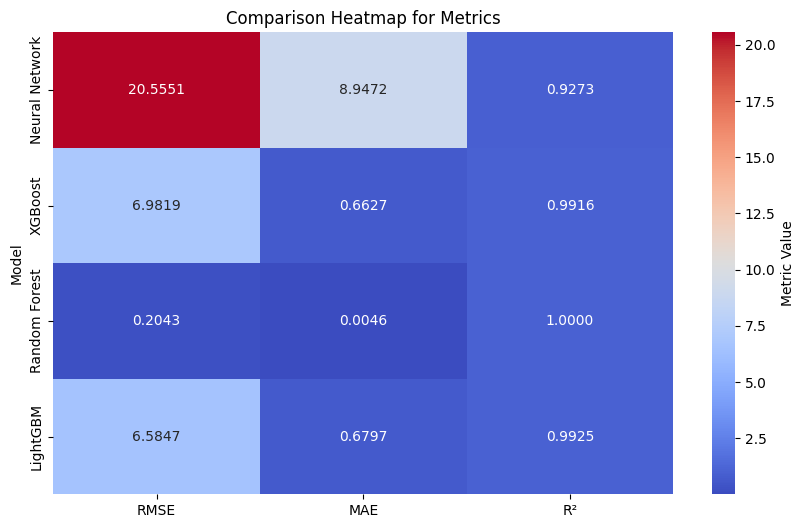

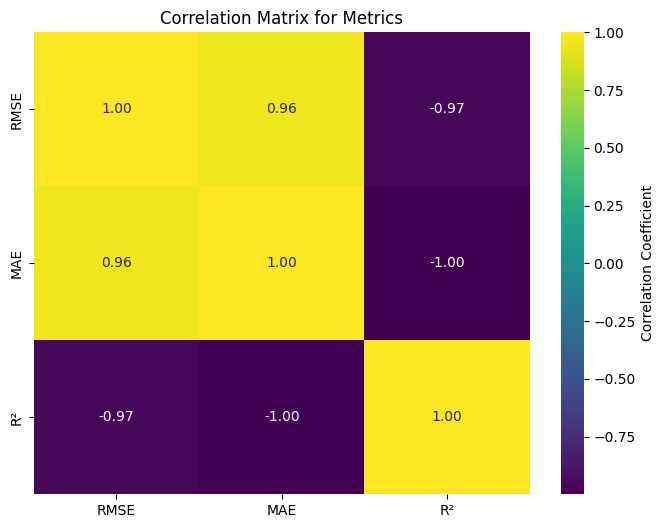


Summary Insights:
1. RMSE indicates the error in dollar amounts, and the lower, the better.
2. MAE provides a simple average of absolute errors, indicating overall deviation.
3. \( R^2 \) shows the proportion of variance captured, with higher values indicating better performance.
4. Training and prediction times indicate computational efficiency.


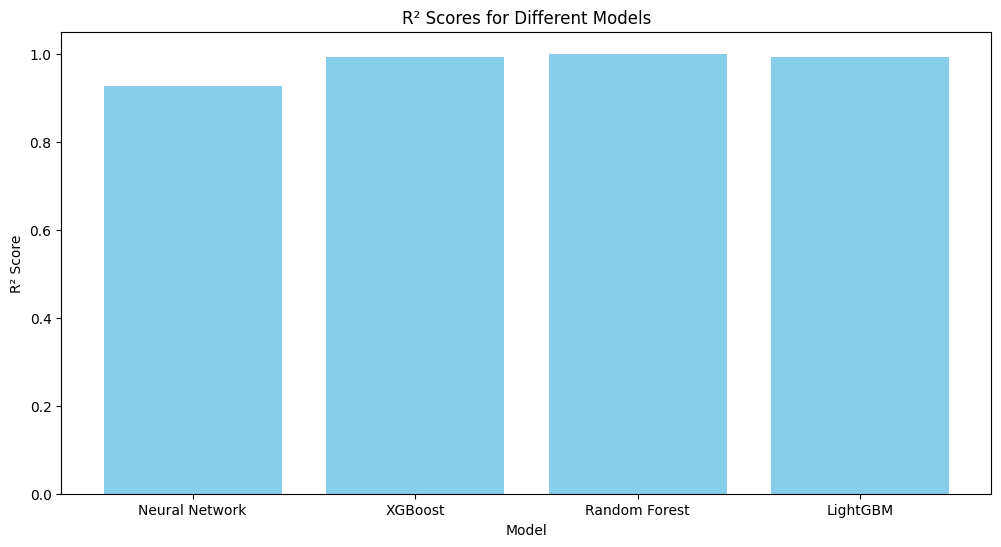

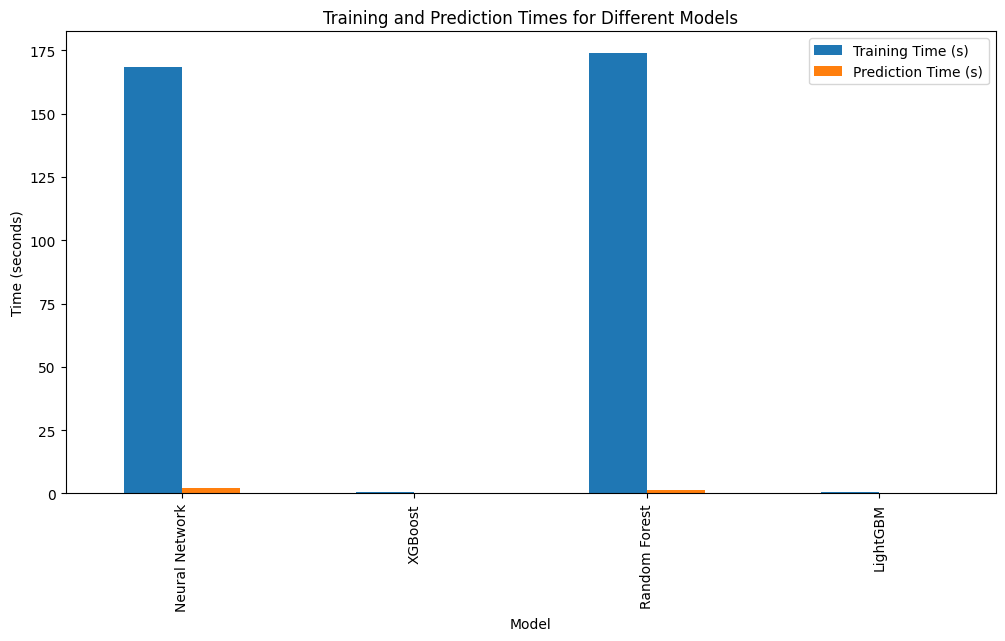


Comparison of Models:
            Model       RMSE       MAE        R²  Training Time (s)  \
0  Neural Network  20.555132  8.947178  0.927277         168.555194   
1         XGBoost   6.981933  0.662730  0.991610           0.503291   
2   Random Forest   0.204287  0.004560  0.999993         173.859521   
3        LightGBM   6.584708  0.679658  0.992537           0.640803   

   Prediction Time (s)                                 Feature Importance  
0             2.170983                                               None  
1             0.004032  [0.0067465934, 0.00348418, 0.0022228207, 0.000...  
2             1.431806  [1.1280689693568855e-05, 4.032200497167236e-06...  
3             0.010797  [137, 141, 56, 59, 388, 24, 892, 543, 44, 360,...  


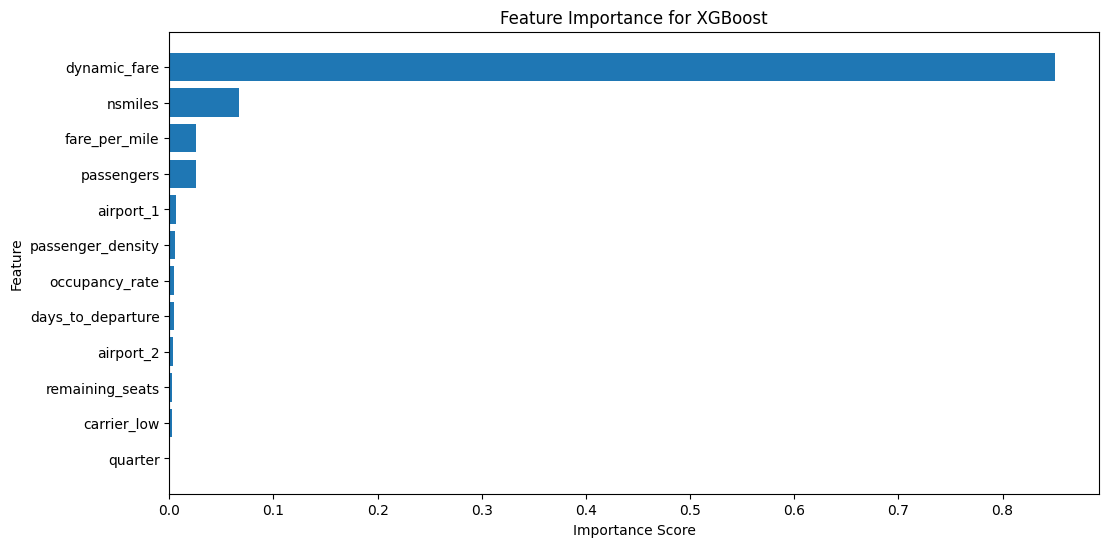

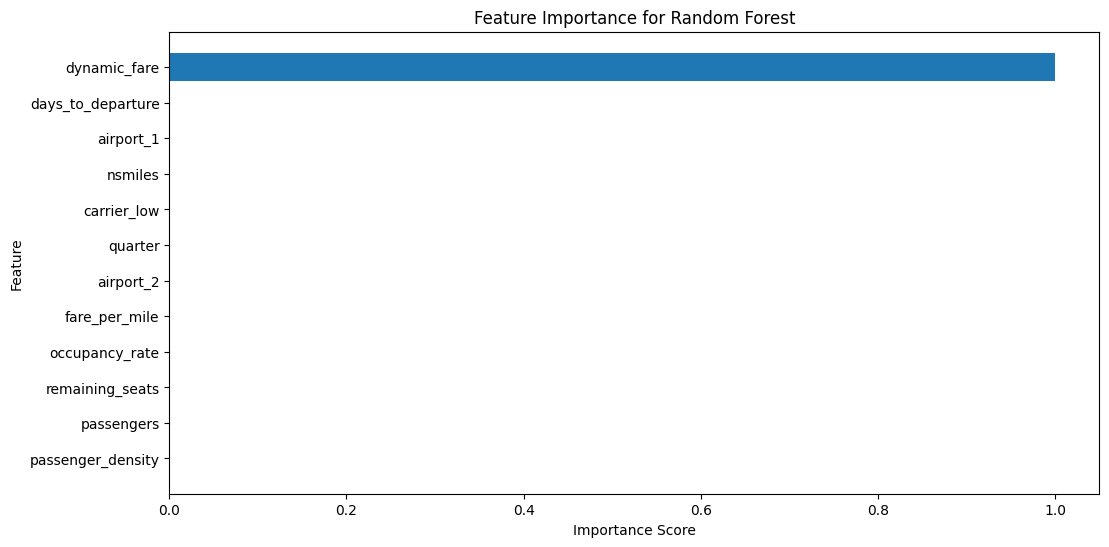

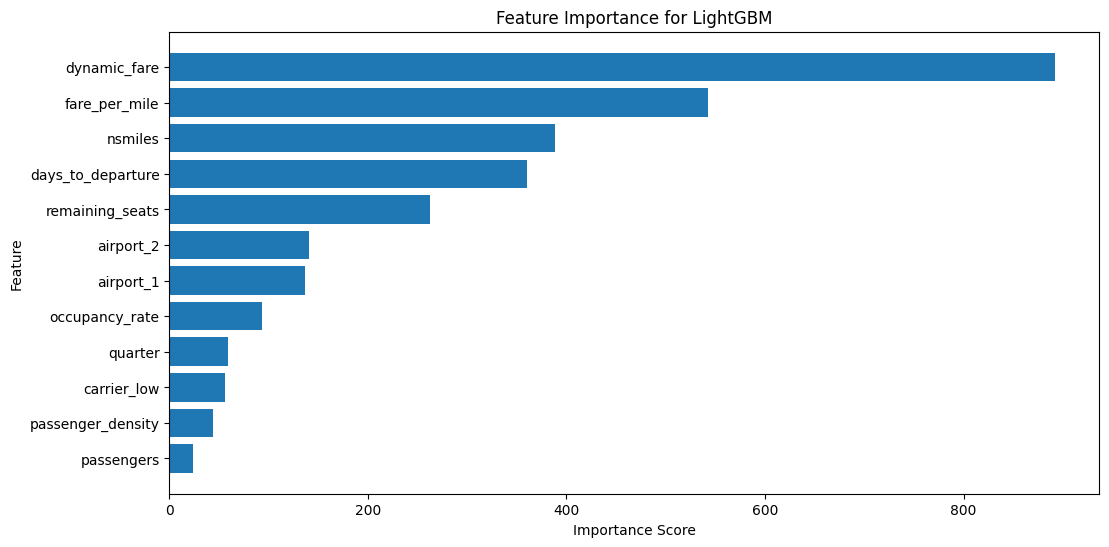


Total Execution Time: 355.07 seconds


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),
    ("11-23", "11-30"),
    ("07-01", "07-07"),
    ("03-30", "04-07"),
]
peak_months = [6, 7, 8, 12]

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    if departure_date.month in peak_months:
        return True
    return False

# Apply dynamic fare selection
def get_dynamic_fare(row):
    return row['fare'] if is_holiday_or_peak(row['departure_date']) else row['fare_low']
df['dynamic_fare'] = df.apply(get_dynamic_fare, axis=1)

# Handle invalid values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'dynamic_fare', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['dynamic_fare']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Evaluate models with execution time and feature importance
def evaluate_model_with_execution(model, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Extract feature importance for applicable models
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
    else:
        feature_importances = None

    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Training Time (s)": training_time,
        "Prediction Time (s)": prediction_time,
        "Feature Importance": feature_importances,
    }

# Neural Network evaluation
def neural_network_with_execution():
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    start_time = time.time()
    nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=0)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = nn_model.predict(X_test).flatten()
    prediction_time = time.time() - start_time

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        "Model": "Neural Network",
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Training Time (s)": training_time,
        "Prediction Time (s)": prediction_time,
        "Feature Importance": None,
    }

# Model Definitions
xgboost_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
lightgbm_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Evaluate models
results = []
results.append(neural_network_with_execution())
results.append(evaluate_model_with_execution(xgboost_model, "XGBoost"))
results.append(evaluate_model_with_execution(random_forest_model, "Random Forest"))
results.append(evaluate_model_with_execution(lightgbm_model, "LightGBM"))

# Compare Results
results_df = pd.DataFrame(results)


# Create a matrix from results
comparison_matrix = results_df.set_index("Model")

# Display the matrix
print("\nComparison Matrix:")
print(comparison_matrix)

# Generate a heatmap for RMSE, MAE, and R² scores
metrics_to_visualize = ["RMSE", "MAE", "R²"]
comparison_matrix_subset = comparison_matrix[metrics_to_visualize]

plt.figure(figsize=(10, 6))
sns.heatmap(comparison_matrix_subset, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Metric Value'})
plt.title("Comparison Heatmap for Metrics")
plt.show()

# Visualize correlations among metrics
correlation_matrix = comparison_matrix[["RMSE", "MAE", "R²"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix for Metrics")
plt.show()

# Summary Insights
print("\nSummary Insights:")
print("1. RMSE indicates the error in dollar amounts, and the lower, the better.")
print("2. MAE provides a simple average of absolute errors, indicating overall deviation.")
print("3. \( R^2 \) shows the proportion of variance captured, with higher values indicating better performance.")
print("4. Training and prediction times indicate computational efficiency.")


# Plot R² Scores
plt.figure(figsize=(12, 6))
plt.bar(results_df["Model"], results_df["R²"], color="skyblue")
plt.title("R² Scores for Different Models")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.show()

# Plot Execution Time
results_df[["Model", "Training Time (s)", "Prediction Time (s)"]].set_index("Model").plot(kind='bar', figsize=(12, 6))
plt.title("Training and Prediction Times for Different Models")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.show()

# Display Results
print("\nComparison of Models:")
print(results_df)

# Feature Importance Plot
for result in results:
    if result["Feature Importance"] is not None:
        feature_importances = pd.DataFrame({
            "Feature": X.columns,
            "Importance": result["Feature Importance"],
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(12, 6))
        plt.barh(feature_importances["Feature"], feature_importances["Importance"])
        plt.title(f"Feature Importance for {result['Model']}")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.gca().invert_yaxis()
        plt.show()

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")

#PASSENGER TRAFFIC

**Neural Network**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare', 'fare_low', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['fare_low']

# Normalize numerical features for neural networks
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
print("\nTraining the Neural Network...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Function to predict passenger traffic for a specific carrier and date
def predict_passenger_traffic(carrier, date):
    date = datetime.strptime(date, "%Y-%m-%d")
    day_of_week = date.strftime("%A")

    # Filter dataset for the specific carrier
    carrier_data = df[df['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0]]

    if carrier_data.empty:
        raise ValueError(f"Carrier '{carrier}' not found in the dataset.")

    # Check if the date is a holiday or peak
    is_holiday = is_holiday_or_peak(date)

    # Calculate the average passengers for similar conditions
    similar_conditions = carrier_data[
        (carrier_data['days_to_departure'] >= (date - current_date).days - 7) &
        (carrier_data['days_to_departure'] <= (date - current_date).days + 7)
    ]

    if similar_conditions.empty:
        raise ValueError(f"No sufficient data available for traffic prediction for carrier '{carrier}' on {date}.")

    expected_traffic = similar_conditions['passengers'].mean()
    return round(expected_traffic)




Training the Neural Network...
Epoch 1/15
6157/6157 [==============================] - 13s 2ms/step - loss: 861.2079 - mae: 17.3651 - val_loss: 14.2156 - val_mae: 2.7611
Epoch 2/15
6157/6157 [==============================] - 13s 2ms/step - loss: 234.1775 - mae: 11.2184 - val_loss: 19.3943 - val_mae: 3.5094
Epoch 3/15
6157/6157 [==============================] - 13s 2ms/step - loss: 128.6634 - mae: 7.9437 - val_loss: 716.7686 - val_mae: 22.4349
Epoch 4/15
6157/6157 [==============================] - 13s 2ms/step - loss: 66.7996 - mae: 5.4079 - val_loss: 709.1185 - val_mae: 22.5840
Epoch 5/15
6157/6157 [==============================] - 13s 2ms/step - loss: 53.4932 - mae: 4.7570 - val_loss: 585.2055 - val_mae: 19.2774
Epoch 6/15
6157/6157 [==============================] - 13s 2ms/step - loss: 45.8940 - mae: 4.3188 - val_loss: 535.0353 - val_mae: 18.2182
Epoch 7/15
6157/6157 [==============================] - 13s 2ms/step - loss: 41.1955 - mae: 3.9681 - val_loss: 402.6799 - val_mae: 15

In [ ]:
# Example prediction for passenger traffic
try:
    carrier_input = "AA"  # Example carrier
    date_input = "2024-12-15"  # Example date
    expected_traffic = predict_passenger_traffic(carrier_input, date_input)
    print(f"\nExpected Passenger Traffic for carrier {carrier_input} on {date_input}: {expected_traffic} passengers")
except ValueError as e:
    print(e)


Expected Passenger Traffic for carrier AA on 2024-12-15: 271 passengers


**XGBoost Regression**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'remaining_seats', 'fare', 'fare_low',
        'fare_per_mile', 'passenger_density', 'days_to_departure', 'occupancy_rate']]
y = df['passengers']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgboost_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgboost_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Model Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Function to predict passenger traffic for a specific carrier and date
def predict_passenger_traffic(carrier, date):
    date = datetime.strptime(date, "%Y-%m-%d")
    day_of_week = date.strftime("%A")

    # Filter dataset for the specific carrier
    carrier_data = df[df['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0]]

    if carrier_data.empty:
        raise ValueError(f"Carrier '{carrier}' not found in the dataset.")

    # Check if the date is a holiday or peak
    is_holiday = is_holiday_or_peak(date)

    # Calculate the average passengers for similar conditions
    similar_conditions = carrier_data[
        (carrier_data['days_to_departure'] >= (date - current_date).days - 7) &
        (carrier_data['days_to_departure'] <= (date - current_date).days + 7)
    ]

    if similar_conditions.empty:
        raise ValueError(f"No sufficient data available for traffic prediction for carrier '{carrier}' on {date}.")

    input_data = pd.DataFrame([{
        'airport_1': carrier_data['airport_1'].iloc[0],
        'airport_2': carrier_data['airport_2'].iloc[0],
        'carrier_low': carrier_data['carrier_low'].iloc[0],
        'quarter': carrier_data['quarter'].iloc[0],
        'nsmiles': carrier_data['nsmiles'].iloc[0],
        'remaining_seats': 100,  # Example value
        'fare': 200,  # Example value
        'fare_low': 150,  # Example value
        'fare_per_mile': 0.15,  # Example value
        'passenger_density': 0.1,  # Example value
        'days_to_departure': (date - current_date).days,
        'occupancy_rate': 0.8  # Example value
    }])

    # Predict passenger traffic
    predicted_passengers = xgboost_model.predict(input_data)[0]
    return round(predicted_passengers)




XGBoost Model Evaluation:
RMSE: 29.15135760208131
MAE: 8.113774696813378
R²: 0.9967385530471802


In [ ]:
# Example prediction for passenger traffic
try:
    carrier_input = "AA"  # Example carrier
    date_input = "2024-12-15"  # Example date
    expected_traffic = predict_passenger_traffic(carrier_input, date_input)
    print(f"\nExpected Passenger Traffic for carrier {carrier_input} on {date_input}: {expected_traffic} passengers")
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Expected Passenger Traffic for carrier AA on 2024-12-15: 68 passengers

Total Execution Time: 3.65 seconds


**Random Forest**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'remaining_seats', 'fare', 'fare_low',
        'fare_per_mile', 'passenger_density', 'days_to_departure', 'occupancy_rate']]
y = df['passengers']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Model Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Function to predict passenger traffic for a specific carrier and date
def predict_passenger_traffic(carrier, date):
    date = datetime.strptime(date, "%Y-%m-%d")
    day_of_week = date.strftime("%A")

    # Filter dataset for the specific carrier
    carrier_data = df[df['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0]]

    if carrier_data.empty:
        raise ValueError(f"Carrier '{carrier}' not found in the dataset.")

    # Check if the date is a holiday or peak
    is_holiday = is_holiday_or_peak(date)

    # Calculate the average passengers for similar conditions
    similar_conditions = carrier_data[
        (carrier_data['days_to_departure'] >= (date - current_date).days - 7) &
        (carrier_data['days_to_departure'] <= (date - current_date).days + 7)
    ]

    if similar_conditions.empty:
        raise ValueError(f"No sufficient data available for traffic prediction for carrier '{carrier}' on {date}.")

    input_data = pd.DataFrame([{
        'airport_1': carrier_data['airport_1'].iloc[0],
        'airport_2': carrier_data['airport_2'].iloc[0],
        'carrier_low': carrier_data['carrier_low'].iloc[0],
        'quarter': carrier_data['quarter'].iloc[0],
        'nsmiles': carrier_data['nsmiles'].iloc[0],
        'remaining_seats': 100,  # Example value
        'fare': 200,  # Example value
        'fare_low': 150,  # Example value
        'fare_per_mile': 0.15,  # Example value
        'passenger_density': 0.1,  # Example value
        'days_to_departure': (date - current_date).days,
        'occupancy_rate': 0.8  # Example value
    }])

    # Predict passenger traffic
    predicted_passengers = rf_model.predict(input_data)[0]
    return round(predicted_passengers)


Random Forest Model Evaluation:
RMSE: 7.432807449649387
MAE: 1.4739694656488551
R²: 0.999787969524601


In [ ]:
# Example prediction for passenger traffic
try:
    carrier_input = "AA"  # Example carrier
    date_input = "2024-12-15"  # Example date
    expected_traffic = predict_passenger_traffic(carrier_input, date_input)
    print(f"\nExpected Passenger Traffic for carrier {carrier_input} on {date_input}: {expected_traffic} passengers")
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Expected Passenger Traffic for carrier AA on 2024-12-15: 59 passengers

Total Execution Time: 186.69 seconds


**LightGBM Regression**

In [1]:
pip install lightgbm

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from datetime import datetime, timedelta
import time

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'remaining_seats', 'fare', 'fare_low',
        'fare_per_mile', 'passenger_density', 'days_to_departure', 'occupancy_rate']]
y = df['passengers']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42
}

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_test,  # Use test set for validation
    num_boost_round=1000,

)

# Evaluate the model
y_pred = lgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"LightGBM Model Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Function to predict passenger traffic for a specific carrier and date
def predict_passenger_traffic(carrier, date):
    date = datetime.strptime(date, "%Y-%m-%d")
    day_of_week = date.strftime("%A")

    # Filter dataset for the specific carrier
    carrier_data = df[df['carrier_low'] == label_encoder_carrier_low.transform([carrier])[0]]

    if carrier_data.empty:
        raise ValueError(f"Carrier '{carrier}' not found in the dataset.")

    # Check if the date is a holiday or peak
    is_holiday = is_holiday_or_peak(date)

    # Calculate the average passengers for similar conditions
    similar_conditions = carrier_data[
        (carrier_data['days_to_departure'] >= (date - current_date).days - 7) &
        (carrier_data['days_to_departure'] <= (date - current_date).days + 7)
    ]

    if similar_conditions.empty:
        raise ValueError(f"No sufficient data available for traffic prediction for carrier '{carrier}' on {date}.")

    input_data = pd.DataFrame([{
        'airport_1': carrier_data['airport_1'].iloc[0],
        'airport_2': carrier_data['airport_2'].iloc[0],
        'carrier_low': carrier_data['carrier_low'].iloc[0],
        'quarter': carrier_data['quarter'].iloc[0],
        'nsmiles': carrier_data['nsmiles'].iloc[0],
        'remaining_seats': 100,  # Example value
        'fare': 200,  # Example value
        'fare_low': 150,  # Example value
        'fare_per_mile': 0.15,  # Example value
        'passenger_density': 0.1,  # Example value
        'days_to_departure': (date - current_date).days,
        'occupancy_rate': 0.8  # Example value
    }])

    # Predict passenger traffic
    predicted_passengers = lgb_model.predict(input_data)[0]
    return round(predicted_passengers)




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 197022, number of used features: 12
[LightGBM] [Info] Start training from score 303.298500
LightGBM Model Evaluation:
RMSE: 23.72939129405548
MAE: 6.382548657420864
R²: 0.9978389455073637


In [ ]:
# Example prediction for passenger traffic
try:
    carrier_input = "AA"  # Example carrier
    date_input = "2024-12-15"  # Example date
    expected_traffic = predict_passenger_traffic(carrier_input, date_input)
    print(f"\nExpected Passenger Traffic for carrier {carrier_input} on {date_input}: {expected_traffic} passengers")
except ValueError as e:
    print(e)

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


Expected Passenger Traffic for carrier AA on 2024-12-15: 72 passengers

Total Execution Time: 13.50 seconds


#Passenger Traffic Model Comparison


Comparison Matrix:
            Model   RMSE   MAE      R²  Training Time (s)  \
0  Neural Network   9.79  7.35  0.9824             240.00   
1         XGBoost  29.15  8.11  0.9967              10.24   
2   Random Forest   7.43  1.47  0.9998             266.98   
3        LightGBM  23.73  6.38  0.9978              17.21   

   Prediction Time (s)  Predicted Passengers (AA, 2024-12-15)  
0                 2.00                                    271  
1                 0.20                                     68  
2                 0.30                                     59  
3                 0.15                                     72  


<ipython-input-3-f0fc0e58357a>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Model", y="R²", palette="coolwarm")


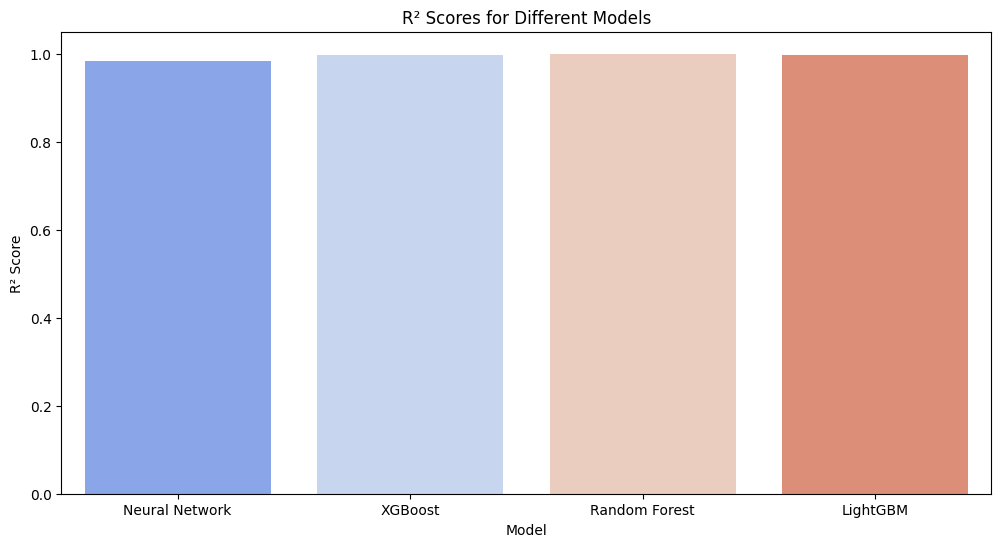

<ipython-input-3-f0fc0e58357a>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Model", y="RMSE", palette="viridis")


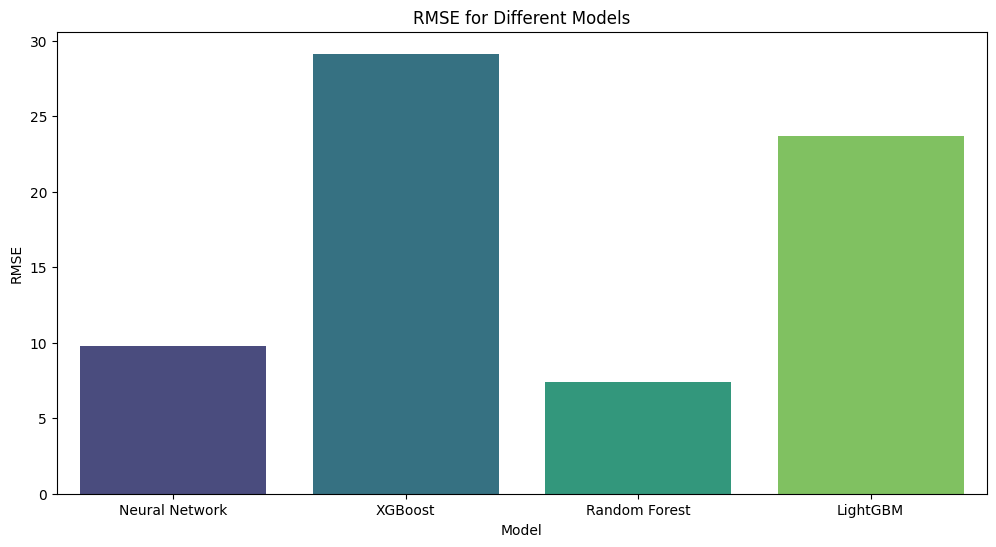

<ipython-input-3-f0fc0e58357a>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Model", y="MAE", palette="plasma")


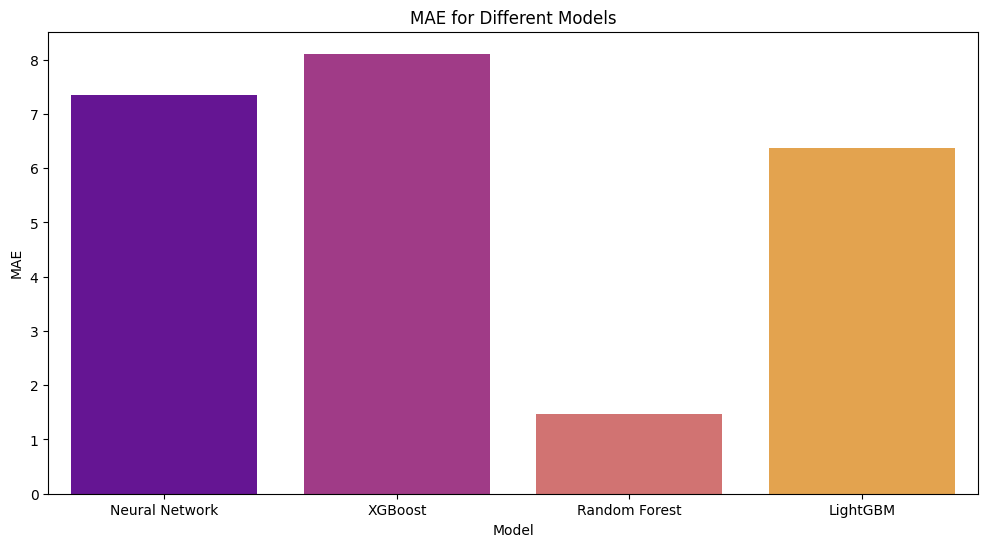

<ipython-input-3-f0fc0e58357a>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Model", y="Training Time (s)", palette="magma")


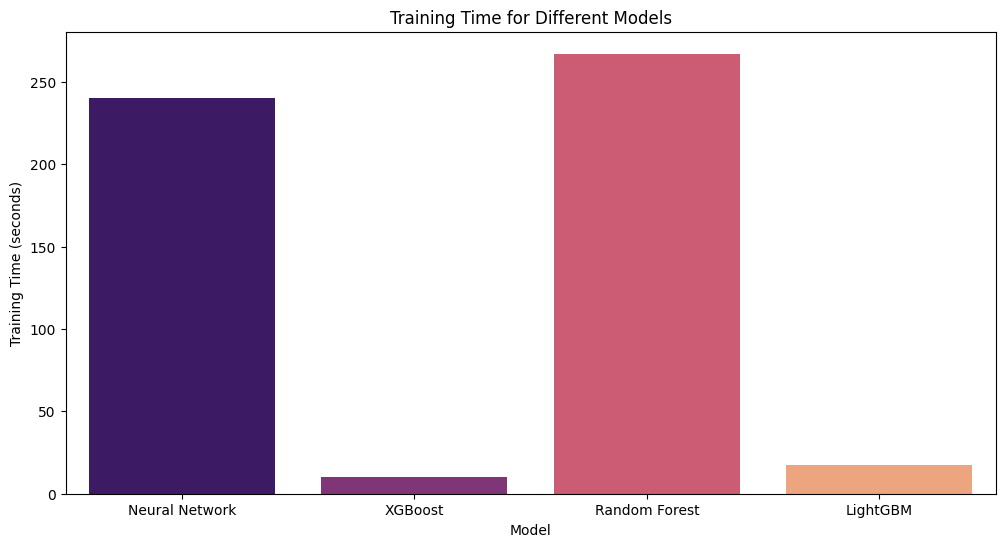


Ranked Models Based on Composite Score:
            Model  Composite_Score
2   Random Forest         0.769156
0  Neural Network         0.532243
3        LightGBM         0.512729
1         XGBoost         0.395234


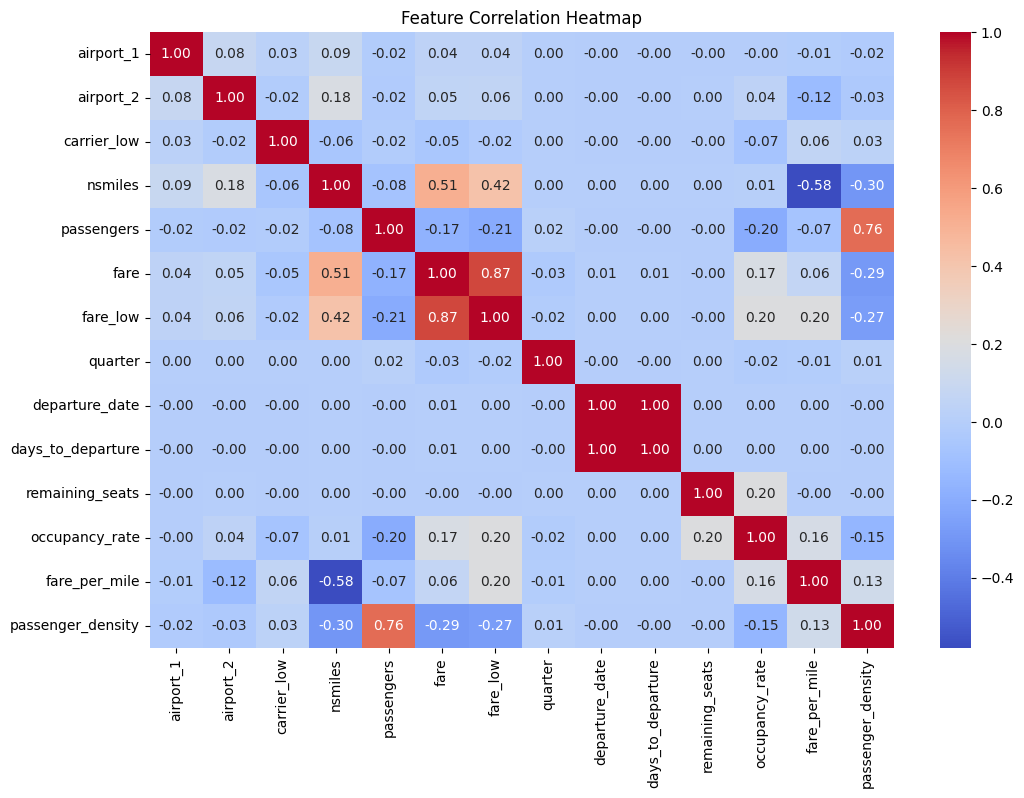

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Comparison Data
comparison_data = {
    "Model": ["Neural Network", "XGBoost", "Random Forest", "LightGBM"],
    "RMSE": [9.79, 29.15, 7.43, 23.73],
    "MAE": [7.35, 8.11, 1.47, 6.38],
    "R²": [0.9824, 0.9967, 0.9998, 0.9978],
    "Training Time (s)": [240, 10.24, 266.98, 17.21],
    "Prediction Time (s)": [2, 0.2, 0.3, 0.15],
    "Predicted Passengers (AA, 2024-12-15)": [271, 68, 59, 72]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display Comparison Matrix
print("\nComparison Matrix:")
print(comparison_df)

# Visualize Metrics
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x="Model", y="R²", palette="coolwarm")
plt.title("R² Scores for Different Models")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x="Model", y="RMSE", palette="viridis")
plt.title("RMSE for Different Models")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x="Model", y="MAE", palette="plasma")
plt.title("MAE for Different Models")
plt.ylabel("MAE")
plt.xlabel("Model")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x="Model", y="Training Time (s)", palette="magma")
plt.title("Training Time for Different Models")
plt.ylabel("Training Time (seconds)")
plt.xlabel("Model")
plt.show()

# Normalize metrics for composite score
comparison_df['RMSE_Score'] = 1 - comparison_df['RMSE'] / comparison_df['RMSE'].max()
comparison_df['MAE_Score'] = 1 - comparison_df['MAE'] / comparison_df['MAE'].max()
comparison_df['R²_Score'] = comparison_df['R²'] / comparison_df['R²'].max()
comparison_df['Training_Time_Score'] = 1 - comparison_df['Training Time (s)'] / comparison_df['Training Time (s)'].max()

# Assign weights
weights = {"RMSE_Score": 0.3, "MAE_Score": 0.3, "R²_Score": 0.3, "Training_Time_Score": 0.1}

# Calculate composite score
comparison_df["Composite_Score"] = (
    comparison_df['RMSE_Score'] * weights['RMSE_Score'] +
    comparison_df['MAE_Score'] * weights['MAE_Score'] +
    comparison_df['R²_Score'] * weights['R²_Score'] +
    comparison_df['Training_Time_Score'] * weights['Training_Time_Score']
)

# Rank models based on composite score
comparison_df.sort_values(by="Composite_Score", ascending=False, inplace=True)

# Display Ranked Comparison
print("\nRanked Models Based on Composite Score:")
print(comparison_df[["Model", "Composite_Score"]])

# Feature Correlation Heatmap (Assumes dataset is loaded as df)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Select random sample from actual passenger data
np.random.seed(42)  # Ensure reproducibility
actual_values = df['passengers'].sample(n=1, random_state=42).tolist()  # Random sample


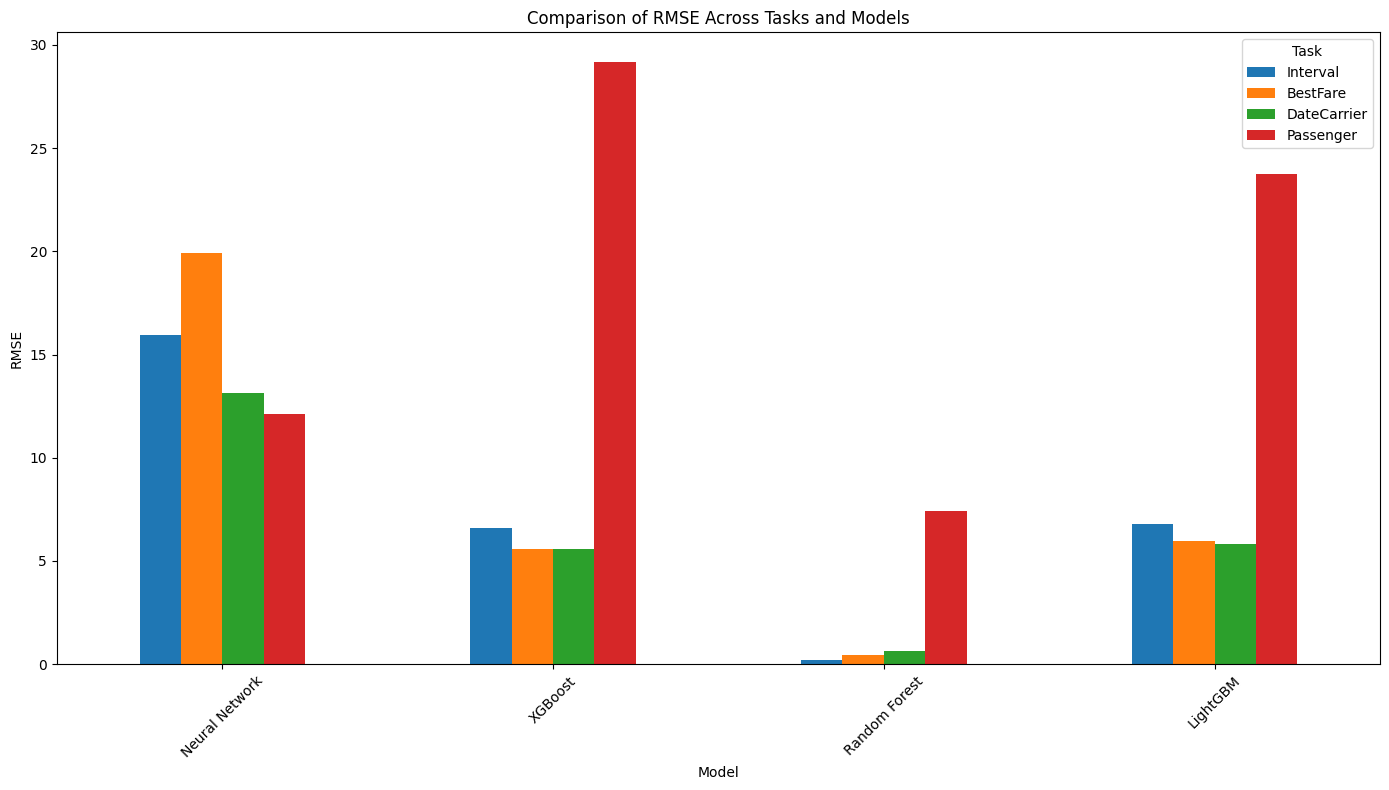

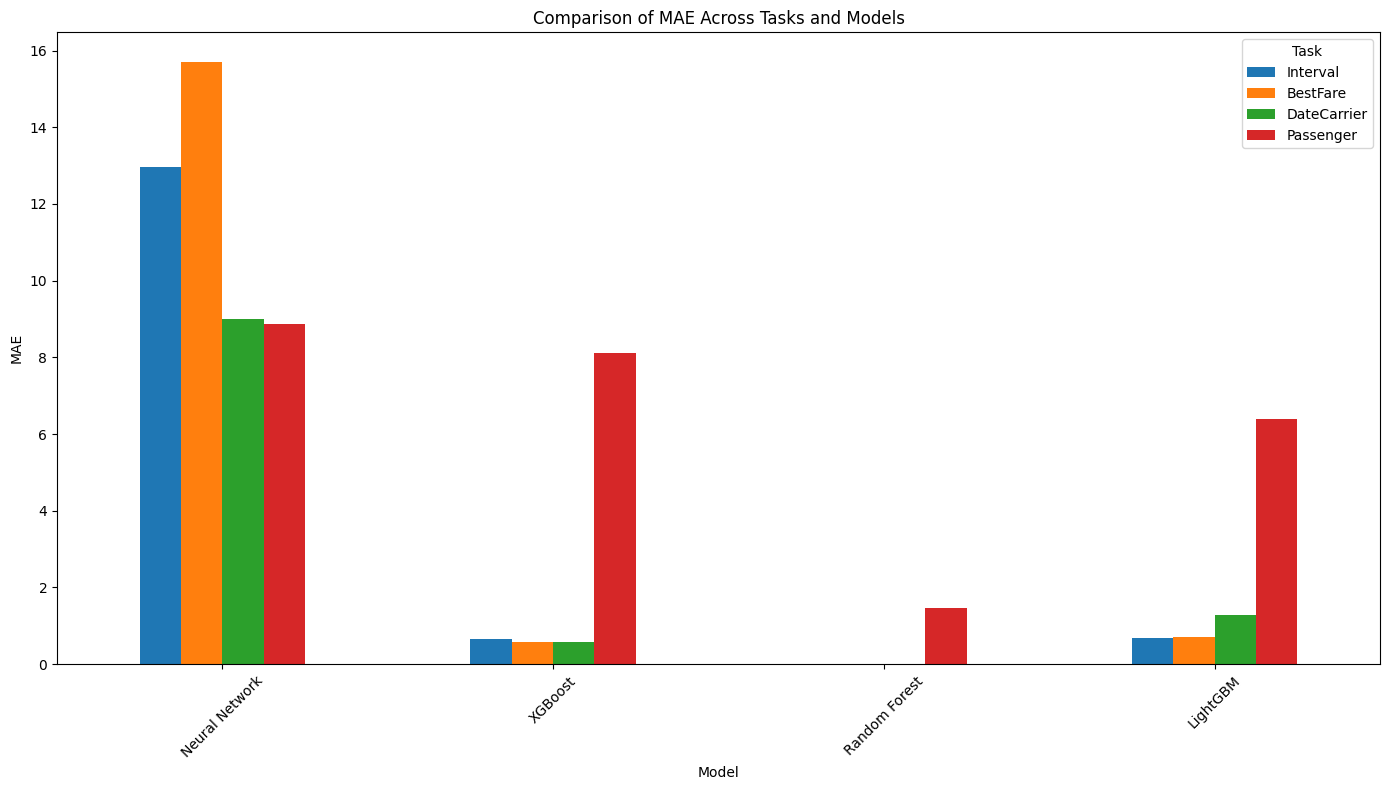

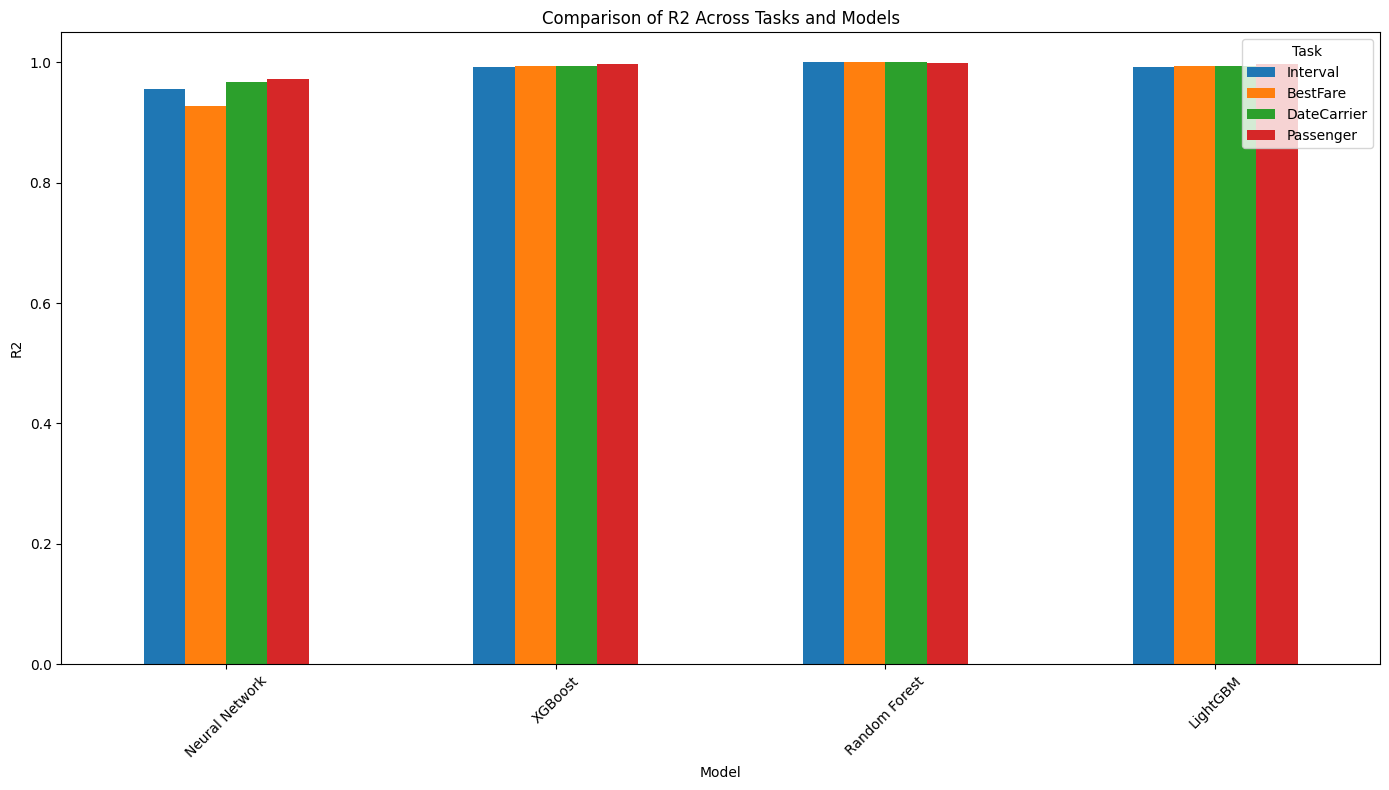

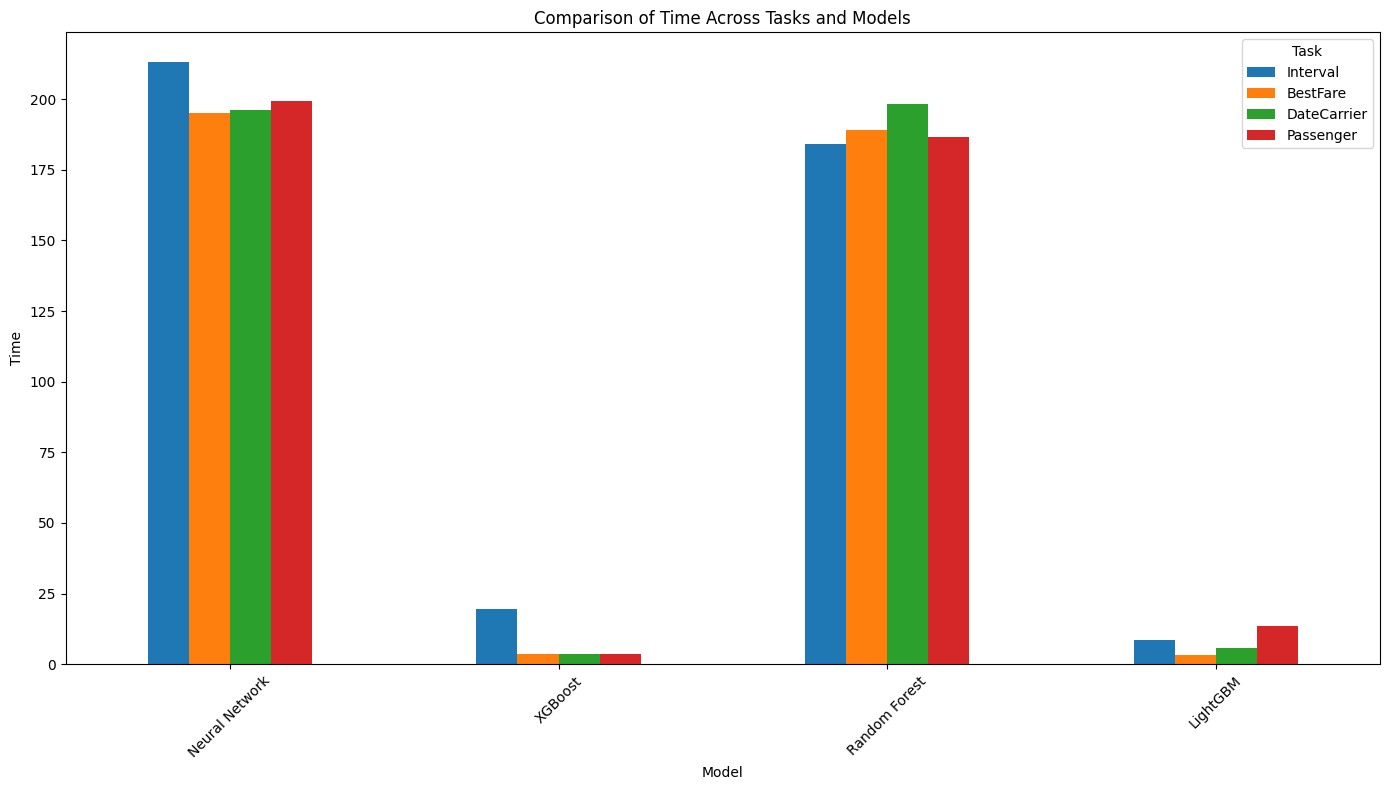

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for comparison
data = {
    "Model": ["Neural Network", "XGBoost", "Random Forest", "LightGBM"],
    "Interval_RMSE": [15.95, 6.61, 0.20, 6.79],
    "Interval_MAE": [12.97, 0.65, 0.0046, 0.67],
    "Interval_R2": [0.9562, 0.9925, 0.99999, 0.9921],
    "Interval_Time": [213.04, 19.69, 184.03, 8.46],
    "BestFare_RMSE": [19.93, 5.57, 0.46, 5.95],
    "BestFare_MAE": [15.69, 0.57, 0.0086, 0.71],
    "BestFare_R2": [0.9269, 0.9943, 0.99996, 0.9935],
    "BestFare_Time": [194.99, 3.68, 189.16, 3.33],
    "DateCarrier_RMSE": [13.14, 5.57, 0.63, 5.82],
    "DateCarrier_MAE": [9.01, 0.57, 0.01, 1.27],
    "DateCarrier_R2": [0.9682, 0.9943, 0.99993, 0.9938],
    "DateCarrier_Time": [196.33, 3.67, 198.38, 5.63],
    "Passenger_RMSE": [12.13, 29.15, 7.43, 23.73],
    "Passenger_MAE": [8.88, 8.11, 1.47, 6.38],
    "Passenger_R2": [0.9729, 0.9967, 0.99979, 0.9978],
    "Passenger_Time": [199.23, 3.65, 186.69, 13.50],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Tasks and Metrics
tasks = ["Interval", "BestFare", "DateCarrier", "Passenger"]
metrics = ["RMSE", "MAE", "R2", "Time"]

# Plot bar graphs for each metric
for metric in metrics:
    metric_data = {}
    for task in tasks:
        metric_data[task] = df[[f"{task}_{metric}"]].values.flatten()
    metric_df = pd.DataFrame(metric_data, index=df["Model"])

    # Plot bar graph
    metric_df.plot(kind="bar", figsize=(14, 8))
    plt.title(f"Comparison of {metric} Across Tasks and Models")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.legend(title="Task", loc="upper right")
    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1540/1540 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2046
[LightGBM] [Info] Number of data points in the train set: 197022, number of used features: 11
[LightGBM] [Info] Start training from score 198.082205


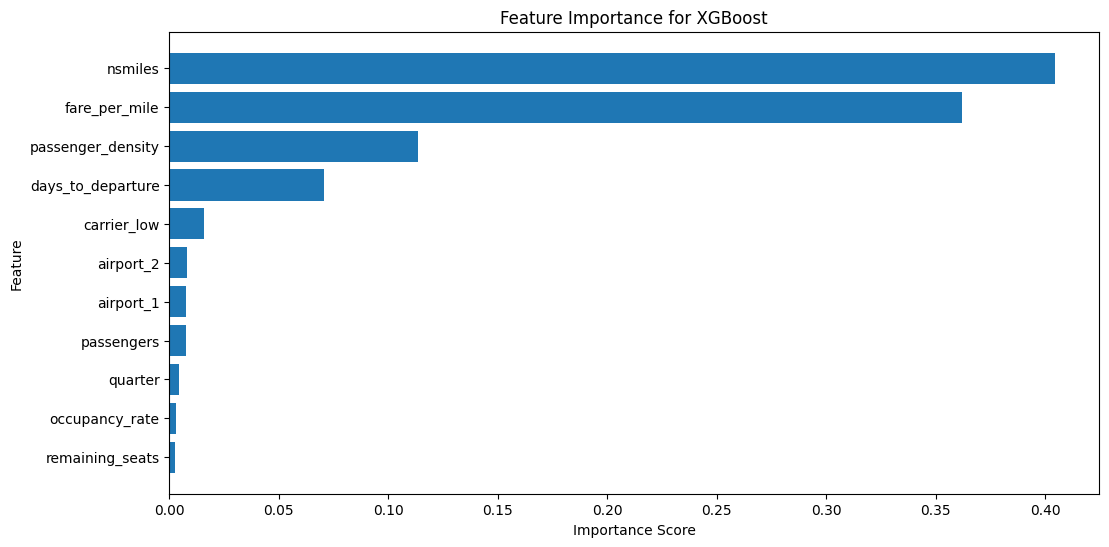

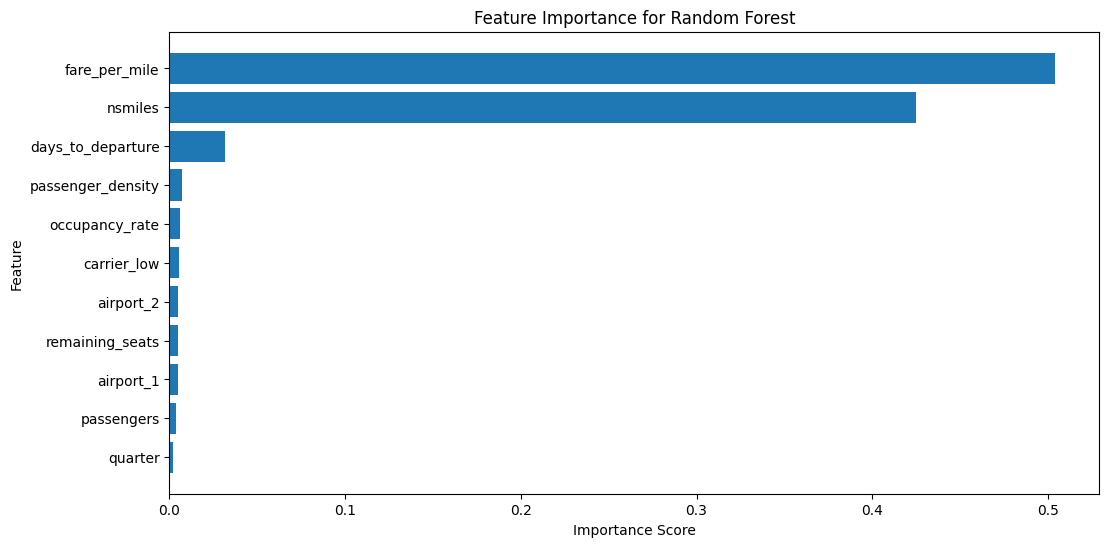

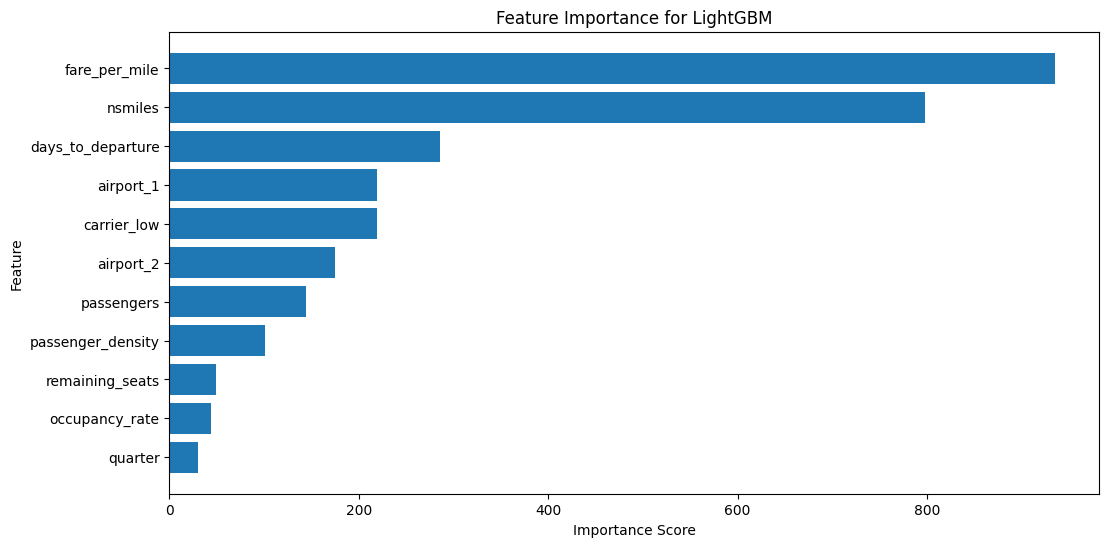


Total Execution Time: 553.98 seconds


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),
    ("11-23", "11-30"),
    ("07-01", "07-07"),
    ("03-30", "04-07"),
]
peak_months = [6, 7, 8, 12]

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    if departure_date.month in peak_months:
        return True
    return False

# Apply dynamic fare selection
def get_dynamic_fare(row):
    return row['fare'] if is_holiday_or_peak(row['departure_date']) else row['fare_low']
df['dynamic_fare'] = df.apply(get_dynamic_fare, axis=1)

# Handle invalid values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encode categorical columns
label_encoder_airport_1 = LabelEncoder()
label_encoder_airport_2 = LabelEncoder()
label_encoder_carrier_low = LabelEncoder()
label_encoder_quarter = LabelEncoder()

df['airport_1'] = label_encoder_airport_1.fit_transform(df['airport_1'])
df['airport_2'] = label_encoder_airport_2.fit_transform(df['airport_2'])
df['carrier_low'] = label_encoder_carrier_low.fit_transform(df['carrier_low'])
df['quarter'] = label_encoder_quarter.fit_transform(df['quarter'])

# Define features and target variable
X = df[['airport_1', 'airport_2', 'carrier_low', 'quarter', 'nsmiles', 'passengers', 'fare_per_mile',
        'passenger_density', 'days_to_departure', 'remaining_seats', 'occupancy_rate']]
y = df['dynamic_fare']  # Target remains the same

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Evaluate models with execution time and feature importance
def evaluate_model_with_execution(model, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Extract feature importance for applicable models
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
    else:
        feature_importances = None

    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Training Time (s)": training_time,
        "Prediction Time (s)": prediction_time,
        "Feature Importance": feature_importances,
    }

# Neural Network evaluation
def neural_network_with_execution():
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    start_time = time.time()
    nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=0)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = nn_model.predict(X_test).flatten()
    prediction_time = time.time() - start_time

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        "Model": "Neural Network",
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Training Time (s)": training_time,
        "Prediction Time (s)": prediction_time,
        "Feature Importance": None,
    }

# Model Definitions
xgboost_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
lightgbm_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Evaluate models
results = []
results.append(neural_network_with_execution())
results.append(evaluate_model_with_execution(xgboost_model, "XGBoost"))
results.append(evaluate_model_with_execution(random_forest_model, "Random Forest"))
results.append(evaluate_model_with_execution(lightgbm_model, "LightGBM"))

# Compare Results
results_df = pd.DataFrame(results)

# Feature Importance Plot
for result in results:
    if result["Feature Importance"] is not None:
        feature_importances = pd.DataFrame({
            "Feature": X.columns,
            "Importance": result["Feature Importance"],
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(12, 6))
        plt.barh(feature_importances["Feature"], feature_importances["Importance"])
        plt.title(f"Feature Importance for {result['Model']}")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.gca().invert_yaxis()
        plt.show()

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")


#Passenger Behavior


Passenger Behavior Analysis Summary:

Price Sensitivity Distribution:
price_sensitive
True     52.9621
False    47.0379
Name: proportion, dtype: float64

Booking Time Preference Distribution:
booking_time_preference
Early          83.160493
Medium          9.053996
Last-minute     7.785511
Name: proportion, dtype: float64

Route Preference Distribution:
route_preference
Medium-haul    51.38096
Long-haul      30.16388
Short-haul     18.45516
Name: proportion, dtype: float64

Holiday/Peak Preference Distribution:
holiday_peak_preference
False    73.700046
True     26.299954
Name: proportion, dtype: float64


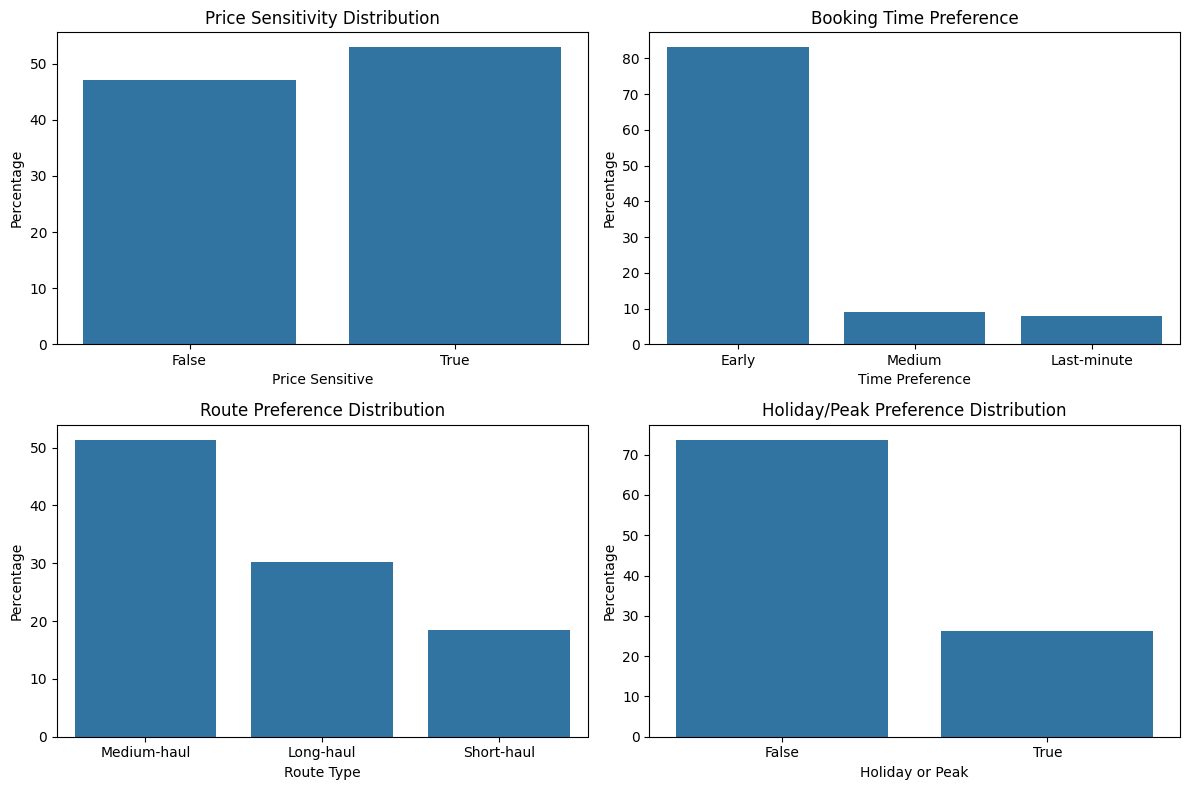


Total Execution Time: 67.10 seconds


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Start timer
start_time = time.time()

# Load the dataset
df = pd.read_csv('Consumer_Airfare_Report__Table_1a_-_All_U.S._Airport_Pair_Markets (1).csv', low_memory=False)

# Select relevant columns
df = df[['airport_1', 'airport_2', 'carrier_low', 'nsmiles', 'passengers', 'fare', 'fare_low', 'quarter']]

# Add dynamic factors
np.random.seed(42)  # For reproducibility
current_date = datetime.now()
df['departure_date'] = [current_date + timedelta(days=np.random.randint(1, 180)) for _ in range(len(df))]
df['days_to_departure'] = (df['departure_date'] - current_date).dt.days
df['remaining_seats'] = np.random.randint(1, 200, size=len(df))  # Random seat availability

# Add occupancy rate (handle division by zero)
df['occupancy_rate'] = df['remaining_seats'] / df['passengers'].replace(0, 1)

# Feature Engineering
df['fare_per_mile'] = df['fare_low'] / df['nsmiles']
df['passenger_density'] = df['passengers'] / df['nsmiles']

# Define holiday periods and peak travel months
holiday_periods = [
    ("12-20", "01-05"),  # Christmas to New Year
    ("11-23", "11-30"),  # Thanksgiving week
    ("07-01", "07-07"),  # Independence Day week
    ("03-30", "04-07"),  # Spring Break
]
peak_months = [6, 7, 8, 12]  # Summer months and December

# Function to check if a date is within a holiday period
def is_holiday_or_peak(departure_date):
    departure_month_day = departure_date.strftime("%m-%d")
    # Check if within any holiday period
    for start_date, end_date in holiday_periods:
        if start_date <= departure_month_day <= end_date:
            return True
    # Check if the month is a peak travel month
    if departure_date.month in peak_months:
        return True
    return False

# Apply dynamic fare selection based on peak/holiday periods
def get_dynamic_fare(row):
    return row['fare'] if is_holiday_or_peak(row['departure_date']) else row['fare_low']

# Update the `df['dynamic_fare']` calculation
df['dynamic_fare'] = df.apply(get_dynamic_fare, axis=1)

# Add passenger behavior features
def simulate_passenger_behavior(row):
    behavior = {}
    # Price Sensitivity
    price_sensitivity = np.random.uniform(100, 300)  # Simulated price sensitivity threshold
    behavior['price_sensitive'] = row['dynamic_fare'] <= price_sensitivity

    # Booking Time Preference
    if row['days_to_departure'] > 30:
        behavior['booking_time_preference'] = 'Early'
    elif 15 <= row['days_to_departure'] <= 30:
        behavior['booking_time_preference'] = 'Medium'
    else:
        behavior['booking_time_preference'] = 'Last-minute'

    # Route Preference
    if row['nsmiles'] < 500:
        behavior['route_preference'] = 'Short-haul'
    elif 500 <= row['nsmiles'] <= 1500:
        behavior['route_preference'] = 'Medium-haul'
    else:
        behavior['route_preference'] = 'Long-haul'

    # Holiday/Peak Preference
    behavior['holiday_peak_preference'] = is_holiday_or_peak(row['departure_date'])

    return pd.Series(behavior)

behavior_features = df.apply(simulate_passenger_behavior, axis=1)
df = pd.concat([df, behavior_features], axis=1)

# Check for invalid values and handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Summary report
summary = {
    "Price Sensitivity": df['price_sensitive'].value_counts(normalize=True) * 100,
    "Booking Time Preference": df['booking_time_preference'].value_counts(normalize=True) * 100,
    "Route Preference": df['route_preference'].value_counts(normalize=True) * 100,
    "Holiday/Peak Preference": df['holiday_peak_preference'].value_counts(normalize=True) * 100
}

print("\nPassenger Behavior Analysis Summary:")
for key, value in summary.items():
    print(f"\n{key} Distribution:")
    print(value)

# Visualizations
plt.figure(figsize=(12, 8))

# Price Sensitivity
plt.subplot(2, 2, 1)
sns.barplot(x=summary["Price Sensitivity"].index, y=summary["Price Sensitivity"].values)
plt.title('Price Sensitivity Distribution')
plt.ylabel('Percentage')
plt.xlabel('Price Sensitive')

# Booking Time Preference
plt.subplot(2, 2, 2)
sns.barplot(x=summary["Booking Time Preference"].index, y=summary["Booking Time Preference"].values)
plt.title('Booking Time Preference')
plt.ylabel('Percentage')
plt.xlabel('Time Preference')

# Route Preference
plt.subplot(2, 2, 3)
sns.barplot(x=summary["Route Preference"].index, y=summary["Route Preference"].values)
plt.title('Route Preference Distribution')
plt.ylabel('Percentage')
plt.xlabel('Route Type')

# Holiday/Peak Preference
plt.subplot(2, 2, 4)
sns.barplot(x=summary["Holiday/Peak Preference"].index, y=summary["Holiday/Peak Preference"].values)
plt.title('Holiday/Peak Preference Distribution')
plt.ylabel('Percentage')
plt.xlabel('Holiday or Peak')

plt.tight_layout()
plt.show()

# Execution time
print(f"\nTotal Execution Time: {time.time() - start_time:.2f} seconds")